In [2]:
import json
import math
import os.path
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from IPython.display import HTML, Image, clear_output, display
from torch.autograd import Variable
from tqdm import tqdm

sys.path.append('..')

In [3]:
import config
import data
import model_IG
import utils

/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
%reload_ext autoreload
%autoreload 2

## Paths, parameters, etc.

In [5]:
# which GPU device to use?
os.environ["CUDA_VISIBLE_DEVICES"] = "0-3"

# path to pretrained model
MODEL_FILE = '../logs/2017-08-04_00.55.19.pth'

# TSV file to write attributions 
ATTRS_TSV = '/scratch/pramodkm/acl18/vqa/tsv/attrs.tsv'

# HTML file to pretty display attributions
# The folder containing the images is assumed to be named "val" 
# and be in the same directory as this HTML
ATTRS_HTML = '/scratch/pramodkm/acl18/vqa/attrs.html'

# Number of steps in Riemann integral computation for Integrated Gradients
NUM_STEPS = 2000

# Sample size of dataset to use in all computations of this notebooks
MAX_NUM_BATCHES = 10000 

# File (EPS format) for writing the overstability curve
OVERSTABILITY_CURVE_FILE = '/scratch/pramodkm/acl18/vqa/overstability.eps'

In [6]:
# Load pretrained model
log = torch.load(MODEL_FILE)
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model_IG.Net(tokens))
net.load_state_dict(log['weights'])

../model_IG.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(w)
../model_IG.py:91: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
../model_IG.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


In [7]:
# Load vocabulary
with open(config.vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)
reverse_vocab_question = dict(
    [(v, k) for k, v in vocab_json['question'].items()])
reverse_vocab_answer = dict([(v, k) for k, v in vocab_json['answer'].items()])

In [8]:
# Extract embedding matrix for question words
question_emb_lookup = log['weights']['module.text.embedding.weight']
embedding = nn.Embedding(
    question_emb_lookup.shape[0], question_emb_lookup.shape[1], padding_idx=0)
embedding.weight.data = question_emb_lookup

In [9]:
# Load validation data
val_loader = data.get_loader(val=True)
LOADER = val_loader
PREFIX = "val"

In [10]:
# Image index dict
reverse_coco_idxs = dict(
    [(v, k) for k, v in val_loader.dataset.coco_id_to_index.items()])

In [11]:
def get_answer(a):
    """ Get the answer that at least 3 turkers have agreed on """
    indices = torch.nonzero(a >= 3)
    if len(indices) == 0:
        return ''
    return '|'.join([reverse_vocab_answer[int(index)] for index in indices])

In [12]:
# Setting up a few items
if not os.path.isdir(os.path.dirname(ATTRS_TSV)):
    os.makedirs(os.path.dirname(ATTRS_TSV))

var_params = {
    'requires_grad': False,
}

# number of batches for the integral summation for computing attributions
num_batches_ig = int(np.ceil(NUM_STEPS/val_loader.batch_size))

## Compute accuracy

In [13]:
# Script to compute attributions for a fixed number of batches
net.eval()
accs = []
num_batches = 0
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)

    acc = utils.batch_accuracy(out.data, a.data).cpu()

    accs.append(np.array(acc.view(-1)))

    del v, q, a, idx, q_len, q_emb, acc, out

    if num_batches >= MAX_NUM_BATCHES:
        break
    num_batches += 1

accs = list(np.concatenate(accs, axis=0))

val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)
val E000:  23% 217/950 [00:25<01:27,  8.38it/s]Process Process-7:
Process Process-5:
Process Process-2:
Process Process-6:
Process Process-3:
Process Process-8:
Process Process-1:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python

KeyboardInterrupt: 

  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 496, in __getitem__
    self.id.read(mspace, fspace, arr, mtype, dxpl=self._dxpl)
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 496, in __getitem__
    self.id.read(mspace, fspace, arr, mtype, dxpl=self._dxpl)
  File "/scratch/pramodkm/tensorflow_gpu_python3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 496, in __getitem__
    self.id.read(mspace, fspace, arr, mtype, dxpl=self._dxpl)
  File "/s

In [41]:
# Accuracy 
print('Accuracy over',len(accs),'inputs:',np.mean(np.array(accs)))

Accuracy over 121512 inputs: 0.6734972677595629
Mean turker agreement over 121512 inputs: 0.6112985


## Compute attributions
Approx running time: 21 hours on GeForce GTX 1080 Ti (12 GB), Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 64GB RAM

In [12]:
padding_embedding = embedding.weight.data[0, :]


def scale_input(q_emb, num_batches=1):
    """ Create scaled versions of input and stack along batch dimension
    q_emb shape = (q_length, emb_dim)
    """
    num_points = config.batch_size*num_batches
    scale = 1.0/num_points
    step = (q_emb.unsqueeze(0) -
            padding_embedding.unsqueeze(0).unsqueeze(0)) * scale
    ans = torch.cat([torch.add(padding_embedding, step*i)
                     for i in range(num_points)], dim=0)
    return ans, step.squeeze()

In [33]:
def compute_attributions(q_emb, q_len, v, idx, num_batches=5, answer=None):
    """ compute attributions for all examples in a given batch """
    ans = ''
    for batch_i in range(int(q_emb.shape[0])):
        scaled_q_emb, step = scale_input(
            q_emb[batch_i, :, :], num_batches=num_batches)
        diff = 0
        total_grads = 0
        repeated_q_len = (torch.ones([config.batch_size] + list(q_len.shape[1:]), dtype=torch.long).cuda(async=True)*q_len[batch_i])
        repeated_v = (torch.ones([config.batch_size] + list(v.shape[1:])).cuda(async=True)*v[batch_i])
        for j in range(num_batches):
            batch_scaled_q_emb = scaled_q_emb[j*config.batch_size:(
                j+1)*config.batch_size]
            with torch.autograd.set_grad_enabled(True):
                scaled_answer, gradients = net(
                    repeated_v, batch_scaled_q_emb, repeated_q_len, compute_gradient=True, ans_index=int(answer[batch_i]))
            # at this point, shape(gradients) = 128 x 23 x 300
            total_grads += torch.sum(gradients, dim=0)
            if j == 0:
                diff -= scaled_answer[0, answer[batch_i]]
                baseline_softmax = scaled_answer[0, :]
            if j == num_batches - 1:
                diff += scaled_answer[-1, answer[batch_i]]
        del scaled_q_emb, repeated_q_len, repeated_v, batch_scaled_q_emb, gradients
        attributions = torch.sum(total_grads * step, dim=1)
        area = torch.sum(attributions, dim=0)
        #print('--------------------------')
        #print(('diff: ', float(diff)))
        #print(('area: ', float(area)))
        if abs(float(diff) - float(area)) > 0.001:
            print(('WARNING: attribution sanity check not matching up!! Diff = ', abs(
                float(diff) - float(area))))

        predicted_answer = reverse_vocab_answer[int(answer[batch_i])]
        correct_answer = get_answer(a[batch_i, :])
        _, baseline_topk_answers = baseline_softmax.topk(1)
        baseline_topk_answers = ', '.join(
            [reverse_vocab_answer[int(i)] for i in baseline_topk_answers])

        if baseline_topk_answers[0] == predicted_answer:
            attributions = attributions*0

        #print('Predicted answer: ', predicted_answer)
        #print('Baseline top k answers : ', ' | '.join(baseline_topk_answers))
        #print('Prediction is correct?: ', int(acc[batch_i]))
        #print('Image ID: ', val_loader.dataset.coco_ids[int(idx[batch_i])])
        question_attrs = []
        for j, w in enumerate(q[batch_i, :]):
            if int(w) != 0:
                #print(reverse_vocab_question[int(w)], ': ', float(attributions[j]))
                question_attrs.append(
                    '|'.join([str(reverse_vocab_question[int(w)]), str(float(attributions[j]))]))
        tsv_string = ['||'.join(question_attrs), baseline_topk_answers, predicted_answer, correct_answer, str(
            int(acc[batch_i])), str(val_loader.dataset.coco_ids[int(idx[batch_i])])]
        ans += '\t'.join(tsv_string) + '\n'
        del attributions, area
    return ans

In [ ]:
# Script to compute attributions for a fixed number of batches
net.train()
accs = []
num_batches = 0
with open(ATTRS_TSV, 'a') as outf:
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:
        if num_batches < 949:
            num_batches += 1
            continue

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        _, answer = out.data.cpu().max(dim=1)

        attrs_tsv_string = compute_attributions(
            q_emb, q_len, v, idx, num_batches=num_batches_ig, answer=answer)

        outf.write(attrs_tsv_string)
        outf.flush()

        accs.append(np.array(acc.view(-1)))
        
        del v, q, a, idx, q_len, q_emb, acc, out, answer

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

accs = list(np.concatenate(accs, axis=0))

## Visualization

In [ ]:
def visualize_attrs(tokens, attrs):
    html_text = ""
    for i, tok in enumerate(tokens):
        r, g, b = get_color(attrs[i])
        html_text += " <strong><span style='size:16;color:rgb(%d,%d,%d)'>%s</span></strong>" % (
            r, g, b, tok)
    return html_text


def get_latex(tokens, attrs):
    ans = ""
    for i, tok in enumerate(tokens):
        [r, g, b] = [w/256.0 for w in get_color(attrs[i])]
        ans += " {\color[rgb]{%f,%f,%f}%s}" % (r, g, b, tok)
    return ans


def normalize_attrs(attrs):
    """ normalize attributions to between -1 and 1 """
    bound = max(abs(attrs.max()), abs(attrs.min()))
    return attrs/bound


def get_color(attr):
    """ attr is assumed to be between -1 and 1 """
    if attr > 0:
        return int(128*attr) + 127, 128 - int(64*attr), 128 - int(64*attr)
    return 128 + int(64*attr), 128 + int(64*attr), int(-128*attr) + 127

In [ ]:
def make_visualization_html(tsv_filename, html_filename):
    html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
    html_str += '<body> <div class="container"> <h3> Visualizations of the attributions for the Visual QA network <br> <small> Red indicates high values, blue and gray indicates low values <br> A green (or red) block before the question indicates whether the network got the answer right (or wrong)</small></h3></div><br>'
    with open(tsv_filename) as f, open(html_filename, 'w') as outf:
        html_str += '<div class="container">'
        html_str += '-'*40 + '<br>'
        outf.write(html_str)
        for line in f:
            line = line.strip()
            question_attrs, baseline_topk_answers, predicted_answer, correct_answer, is_correct, image_id = line.split(
                '\t')
            question_tokens = []
            attrs = []
            for word_attr in question_attrs.split(','):
                word, attr = word_attr.split('|')
                question_tokens.append(word)
                attrs.append(float(attr))
            html_str = visualize_attrs(
                question_tokens, normalize_attrs(np.array(attrs)))

            if is_correct == '1':
                html_str = '<span style="background-color:green">&nbsp&nbsp</span> ' + html_str
            else:
                html_str = '<span style="background-color:red">&nbsp&nbsp</span> ' + html_str
            html_str += '<br>(prediction, ground truth) = (' + predicted_answer + ', ' + correct_answer + ')'
            html_str += '<br>prediction :' + predicted_answer
            html_str += '<br>baseline topk answers: ' + baseline_topk_answers
            html_str += '<br>image ID: ' + str(image_id)
            html_str += '<br><img src="val2014/COCO_val2014_' + '0' * \
                (12 - len(str(image_id))) + str(image_id) + \
                '.jpg" width="256" height="256"></img><br><br>'
            #display(Image('/scratch/pramodkm/vqa/data_vqa1.0/val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg', width=256, height=256))
            outf.write(html_str + '\n')
        outf.write('</div></body>')

In [ ]:
make_visualization_html(tsv_filename = ATTRS_TSV, 
                       html_filename = ATTRS_HTML)

## Attack by prefixing sentences

In [14]:
def question_concatenation_accuracy(net, phrase, suffix=False):
    """ compute accuracy when phrases are prefixed/suffixed """
    net.eval()
    
    prefix = []
    for word in phrase.split():
        prefix.append(vocab_json['question'][word])
    prefix = torch.LongTensor(prefix) 
    prefix = prefix.unsqueeze(0).repeat(config.batch_size,1)
    accs = []
    num_batches = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:
        curr_batch_size = int(q.shape[0])
        if not suffix:
            q = torch.cat([prefix[:curr_batch_size], q], dim=1)[:,:23] ## 23 because question_length is configured to cap at 23
        else:
            for i in range(curr_batch_size):
                nnz_ix = int((torch.nonzero(q[i,:].cpu())).squeeze().max()) + 1
                if nnz_ix >= q.shape[1]:
                    continue
                q[i, nnz_ix:] = prefix[0, :23-nnz_ix]
        q = q.contiguous()
        
        q_len = q_len + prefix.shape[1]
        q_len = torch.min(q_len, torch.LongTensor([23]).expand_as(q_len))


        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))
        del v, q, a, idx, q_len, q_emb, acc, out

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs, axis=0))
    return accs

In [15]:
PHRASES = [
    'in not a lot of words',
    'in not many words',
    'what is the answer to',
    'tell me',
    'answer this',
    'answer this for me'
]

prefix_attack_accs = []
for phrase in PHRASES:
    prefix_attack_accs.append(question_concatenation_accuracy(net, phrase))


val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:01<22:13,  1.40s/it]
val E000:   0% 3/950 [00:01<09:02,  1.74it/s]
val E000:   1% 5/950 [00:01<05:46,  2.73it/s]
val E000:   1% 7/950 [00:01<04:25,  3.55it/s]
val E000:   1% 9/950 [00:03<05:32,  2.83it/s]
val E000:   1% 11/950 [00:03<04:41,  3.34it/s]
val E000:   1% 13/950 [00:03<04:05,  3.82it/s]
val E000:   2% 15/950 [00:03<03:39,  4.26it/s]
val E000:   2% 17/950 [00:03<03:32,  4.38it/s]
val E000:   2% 20/950 [00:04<03:07,  4.95it/s]
val E000:   2% 22/950 [00:04<02:57,  5.22it/s]
val E000:   3% 24/950 [00:04<02:56,  5.25it/s]
val E000:   3% 26/950 [00:04<02:54,  5.28it/s]
val E000:   3% 28/950 [00:05<02:45,  5.57it/s]
val E000:   3% 30/950 [00:05<02:39,  5.75it/s]
val E000:   3% 32/950 [00:05<02:35,  5.89it/s]
val E000:   4% 34/950 [00:05<02:33,  5

val E000:  24% 224/950 [00:29<01:34,  7.70it/s]
val E000:  24% 226/950 [00:38<02:02,  5.92it/s]
val E000:  24% 227/950 [00:39<02:06,  5.72it/s]
val E000:  24% 228/950 [00:40<02:06,  5.69it/s]
val E000:  24% 229/950 [00:41<02:09,  5.58it/s]
val E000:  24% 230/950 [00:41<02:10,  5.52it/s]
val E000:  24% 232/950 [00:42<02:10,  5.52it/s]
val E000:  25% 234/950 [00:51<02:37,  4.55it/s]
val E000:  25% 235/950 [00:53<02:42,  4.41it/s]
val E000:  25% 236/950 [00:53<02:41,  4.41it/s]
val E000:  25% 237/950 [00:53<02:41,  4.40it/s]
val E000:  25% 238/950 [00:54<02:42,  4.38it/s]
val E000:  25% 240/950 [00:55<02:43,  4.34it/s]
val E000:  25% 242/950 [01:04<03:08,  3.76it/s]
val E000:  26% 243/950 [01:05<03:11,  3.69it/s]
val E000:  26% 244/950 [01:06<03:11,  3.69it/s]
val E000:  26% 245/950 [01:06<03:12,  3.66it/s]
val E000:  26% 246/950 [01:07<03:11,  3.67it/s]
val E000:  26% 248/950 [01:08<03:12,  3.64it/s]
val E000:  26% 250/950 [01:17<03:35,  3.24it/s]
val E000:  26% 251/950 [01:17<03:35,  3.

val E000:  55% 526/950 [07:27<06:00,  1.18it/s]
val E000:  55% 527/950 [07:27<05:59,  1.18it/s]
val E000:  56% 528/950 [07:30<06:00,  1.17it/s]
val E000:  56% 530/950 [07:36<06:01,  1.16it/s]
val E000:  56% 533/950 [07:36<05:57,  1.17it/s]
val E000:  56% 536/950 [07:40<05:55,  1.17it/s]
val E000:  57% 538/950 [07:45<05:56,  1.16it/s]
val E000:  57% 539/950 [07:45<05:54,  1.16it/s]
val E000:  57% 542/950 [07:45<05:50,  1.16it/s]
val E000:  57% 543/950 [07:45<05:49,  1.17it/s]
val E000:  57% 544/950 [07:50<05:50,  1.16it/s]
val E000:  57% 546/950 [07:54<05:51,  1.15it/s]
val E000:  58% 549/950 [07:54<05:46,  1.16it/s]
val E000:  58% 550/950 [07:55<05:45,  1.16it/s]
val E000:  58% 552/950 [07:59<05:45,  1.15it/s]
val E000:  58% 554/950 [08:06<05:47,  1.14it/s]
val E000:  59% 557/950 [08:06<05:43,  1.15it/s]
val E000:  59% 559/950 [08:07<05:40,  1.15it/s]
val E000:  59% 560/950 [08:09<05:41,  1.14it/s]
val E000:  59% 562/950 [08:15<05:42,  1.13it/s]
val E000:  59% 565/950 [08:15<05:37,  1.

val E000:  89% 841/950 [12:07<01:34,  1.16it/s]
val E000:  89% 842/950 [12:07<01:33,  1.16it/s]
val E000:  89% 843/950 [12:09<01:32,  1.15it/s]
val E000:  89% 844/950 [12:12<01:32,  1.15it/s]
val E000:  89% 845/950 [12:14<01:31,  1.15it/s]
val E000:  89% 846/950 [12:15<01:30,  1.15it/s]
val E000:  89% 849/950 [12:15<01:27,  1.15it/s]
val E000:  89% 850/950 [12:15<01:26,  1.16it/s]
val E000:  90% 851/950 [12:18<01:25,  1.15it/s]
val E000:  90% 852/950 [12:21<01:25,  1.15it/s]
val E000:  90% 854/950 [12:22<01:23,  1.15it/s]
val E000:  90% 856/950 [12:22<01:21,  1.15it/s]
val E000:  90% 857/950 [12:23<01:20,  1.15it/s]
val E000:  90% 858/950 [12:23<01:19,  1.15it/s]
val E000:  90% 859/950 [12:25<01:18,  1.15it/s]
val E000:  91% 860/950 [12:28<01:18,  1.15it/s]
val E000:  91% 861/950 [12:29<01:17,  1.15it/s]
val E000:  91% 862/950 [12:29<01:16,  1.15it/s]
val E000:  91% 863/950 [12:30<01:15,  1.15it/s]
val E000:  91% 865/950 [12:30<01:13,  1.15it/s]
val E000:  91% 866/950 [12:30<01:12,  1.

val E000:  17% 159/950 [00:18<01:32,  8.58it/s]
val E000:  17% 161/950 [00:18<01:31,  8.63it/s]
val E000:  17% 163/950 [00:18<01:31,  8.64it/s]
val E000:  17% 165/950 [00:19<01:31,  8.62it/s]
val E000:  17% 166/950 [00:19<01:30,  8.62it/s]
val E000:  18% 167/950 [00:19<01:31,  8.59it/s]
val E000:  18% 169/950 [00:19<01:30,  8.64it/s]
val E000:  18% 171/950 [00:19<01:30,  8.65it/s]
val E000:  18% 173/950 [00:20<01:29,  8.65it/s]
val E000:  18% 175/950 [00:20<01:29,  8.64it/s]
val E000:  19% 177/950 [00:20<01:29,  8.65it/s]
val E000:  19% 178/950 [00:20<01:29,  8.65it/s]
val E000:  19% 180/950 [00:20<01:28,  8.66it/s]
val E000:  19% 181/950 [00:20<01:28,  8.65it/s]
val E000:  19% 182/950 [00:21<01:29,  8.62it/s]
val E000:  19% 183/950 [00:21<01:29,  8.59it/s]
val E000:  19% 185/950 [00:21<01:28,  8.64it/s]
val E000:  20% 187/950 [00:21<01:28,  8.66it/s]
val E000:  20% 189/950 [00:21<01:27,  8.67it/s]
val E000:  20% 191/950 [00:21<01:27,  8.69it/s]
val E000:  20% 193/950 [00:22<01:27,  8.

val E000:  42% 401/950 [00:44<01:01,  8.96it/s]
val E000:  42% 403/950 [00:44<01:01,  8.96it/s]
val E000:  43% 405/950 [00:45<01:00,  8.97it/s]
val E000:  43% 407/950 [00:45<01:00,  8.97it/s]
val E000:  43% 409/950 [00:45<01:00,  8.98it/s]
val E000:  43% 411/950 [00:45<00:59,  8.99it/s]
val E000:  43% 413/950 [00:45<00:59,  8.99it/s]
val E000:  44% 415/950 [00:46<00:59,  9.00it/s]
val E000:  44% 417/950 [00:46<00:59,  9.01it/s]
val E000:  44% 419/950 [00:46<00:58,  9.01it/s]
val E000:  44% 421/950 [00:46<00:58,  9.01it/s]
val E000:  45% 423/950 [00:46<00:58,  9.01it/s]
val E000:  45% 424/950 [00:47<00:58,  9.01it/s]
val E000:  45% 426/950 [00:47<00:58,  9.02it/s]
val E000:  45% 427/950 [00:47<00:57,  9.02it/s]
val E000:  45% 429/950 [00:47<00:57,  9.02it/s]
val E000:  45% 430/950 [00:47<00:57,  9.02it/s]
val E000:  45% 431/950 [00:47<00:57,  9.01it/s]
val E000:  45% 432/950 [00:47<00:57,  9.01it/s]
val E000:  46% 433/950 [00:48<00:57,  9.01it/s]
val E000:  46% 434/950 [00:48<00:57,  9.

val E000:  64% 612/950 [01:07<00:37,  9.03it/s]
val E000:  65% 614/950 [01:07<00:37,  9.03it/s]
val E000:  65% 616/950 [01:08<00:36,  9.04it/s]
val E000:  65% 618/950 [01:08<00:36,  9.04it/s]
val E000:  65% 619/950 [01:08<00:36,  9.03it/s]
val E000:  65% 621/950 [01:08<00:36,  9.05it/s]
val E000:  66% 623/950 [01:08<00:36,  9.05it/s]
val E000:  66% 625/950 [01:09<00:35,  9.05it/s]
val E000:  66% 627/950 [01:09<00:35,  9.05it/s]
val E000:  66% 629/950 [01:09<00:35,  9.06it/s]
val E000:  66% 631/950 [01:09<00:35,  9.06it/s]
val E000:  67% 633/950 [01:09<00:34,  9.06it/s]
val E000:  67% 635/950 [01:10<00:34,  9.07it/s]
val E000:  67% 637/950 [01:10<00:34,  9.07it/s]
val E000:  67% 638/950 [01:10<00:34,  9.07it/s]
val E000:  67% 639/950 [01:10<00:34,  9.06it/s]
val E000:  67% 641/950 [01:10<00:34,  9.07it/s]
val E000:  68% 642/950 [01:10<00:33,  9.07it/s]
val E000:  68% 643/950 [01:10<00:33,  9.07it/s]
val E000:  68% 645/950 [01:11<00:33,  9.07it/s]
val E000:  68% 646/950 [01:11<00:33,  9.

val E000:  93% 883/950 [01:36<00:07,  9.14it/s]
val E000:  93% 884/950 [01:36<00:07,  9.13it/s]
val E000:  93% 886/950 [01:36<00:07,  9.14it/s]
val E000:  93% 888/950 [01:37<00:06,  9.14it/s]
val E000:  94% 890/950 [01:37<00:06,  9.14it/s]
val E000:  94% 892/950 [01:37<00:06,  9.14it/s]
val E000:  94% 894/950 [01:37<00:06,  9.14it/s]
val E000:  94% 896/950 [01:38<00:05,  9.14it/s]
val E000:  95% 898/950 [01:38<00:05,  9.14it/s]
val E000:  95% 900/950 [01:38<00:05,  9.15it/s]
val E000:  95% 902/950 [01:38<00:05,  9.15it/s]
val E000:  95% 904/950 [01:38<00:05,  9.15it/s]
val E000:  95% 905/950 [01:39<00:04,  9.14it/s]
val E000:  95% 906/950 [01:39<00:04,  9.14it/s]
val E000:  96% 908/950 [01:39<00:04,  9.14it/s]
val E000:  96% 909/950 [01:39<00:04,  9.14it/s]
val E000:  96% 910/950 [01:39<00:04,  9.14it/s]
val E000:  96% 912/950 [01:39<00:04,  9.13it/s]
val E000:  96% 914/950 [01:40<00:03,  9.14it/s]
val E000:  96% 916/950 [01:40<00:03,  9.14it/s]
val E000:  97% 918/950 [01:40<00:03,  9.

val E000:  19% 177/950 [00:20<01:31,  8.45it/s]
val E000:  19% 178/950 [00:21<01:31,  8.46it/s]
val E000:  19% 179/950 [00:21<01:31,  8.46it/s]
val E000:  19% 180/950 [00:21<01:30,  8.47it/s]
val E000:  19% 181/950 [00:21<01:30,  8.47it/s]
val E000:  19% 182/950 [00:21<01:30,  8.47it/s]
val E000:  19% 183/950 [00:21<01:30,  8.48it/s]
val E000:  19% 184/950 [00:21<01:30,  8.48it/s]
val E000:  19% 185/950 [00:21<01:30,  8.49it/s]
val E000:  20% 186/950 [00:22<01:30,  8.45it/s]
val E000:  20% 188/950 [00:22<01:29,  8.49it/s]
val E000:  20% 190/950 [00:22<01:29,  8.49it/s]
val E000:  20% 191/950 [00:22<01:29,  8.50it/s]
val E000:  20% 192/950 [00:22<01:29,  8.49it/s]
val E000:  20% 193/950 [00:22<01:29,  8.49it/s]
val E000:  20% 194/950 [00:22<01:29,  8.49it/s]
val E000:  21% 195/950 [00:22<01:28,  8.49it/s]
val E000:  21% 197/950 [00:23<01:28,  8.51it/s]
val E000:  21% 198/950 [00:23<01:28,  8.51it/s]
val E000:  21% 199/950 [00:23<01:28,  8.51it/s]
val E000:  21% 200/950 [00:23<01:28,  8.

val E000:  43% 409/950 [00:46<01:01,  8.80it/s]
val E000:  43% 411/950 [00:46<01:01,  8.81it/s]
val E000:  43% 412/950 [00:46<01:01,  8.79it/s]
val E000:  44% 414/950 [00:46<01:00,  8.81it/s]
val E000:  44% 416/950 [00:47<01:00,  8.82it/s]
val E000:  44% 418/950 [00:47<01:00,  8.83it/s]
val E000:  44% 420/950 [00:47<01:00,  8.81it/s]
val E000:  44% 422/950 [00:47<00:59,  8.82it/s]
val E000:  45% 423/950 [00:47<00:59,  8.82it/s]
val E000:  45% 424/950 [00:48<00:59,  8.82it/s]
val E000:  45% 425/950 [00:48<00:59,  8.81it/s]
val E000:  45% 426/950 [00:48<00:59,  8.81it/s]
val E000:  45% 428/950 [00:48<00:59,  8.82it/s]
val E000:  45% 430/950 [00:48<00:58,  8.82it/s]
val E000:  45% 432/950 [00:48<00:58,  8.83it/s]
val E000:  46% 434/950 [00:49<00:58,  8.84it/s]
val E000:  46% 436/950 [00:49<00:58,  8.84it/s]
val E000:  46% 438/950 [00:49<00:57,  8.85it/s]
val E000:  46% 440/950 [00:49<00:57,  8.85it/s]
val E000:  46% 441/950 [00:49<00:57,  8.85it/s]
val E000:  47% 442/950 [00:49<00:57,  8.

val E000:  72% 682/950 [01:15<00:29,  8.98it/s]
val E000:  72% 683/950 [01:16<00:29,  8.98it/s]
val E000:  72% 684/950 [01:16<00:29,  8.98it/s]
val E000:  72% 686/950 [01:16<00:29,  8.98it/s]
val E000:  72% 688/950 [01:16<00:29,  8.98it/s]
val E000:  73% 690/950 [01:16<00:28,  8.99it/s]
val E000:  73% 691/950 [01:16<00:28,  8.99it/s]
val E000:  73% 692/950 [01:17<00:28,  8.98it/s]
val E000:  73% 695/950 [01:17<00:28,  9.00it/s]
val E000:  73% 697/950 [01:17<00:28,  9.00it/s]
val E000:  74% 699/950 [01:17<00:27,  9.00it/s]
val E000:  74% 701/950 [01:17<00:27,  9.00it/s]
val E000:  74% 703/950 [01:18<00:27,  9.01it/s]
val E000:  74% 705/950 [01:18<00:27,  9.01it/s]
val E000:  74% 707/950 [01:18<00:26,  9.01it/s]
val E000:  75% 709/950 [01:18<00:26,  9.00it/s]
val E000:  75% 711/950 [01:18<00:26,  9.01it/s]
val E000:  75% 712/950 [01:19<00:26,  9.01it/s]
val E000:  75% 714/950 [01:19<00:26,  9.01it/s]
val E000:  75% 716/950 [01:19<00:25,  9.01it/s]
val E000:  75% 717/950 [01:19<00:25,  9.

val E000:  99% 943/950 [01:43<00:00,  9.09it/s]
val E000:  99% 945/950 [01:43<00:00,  9.10it/s]
val E000: 100% 947/950 [01:44<00:00,  9.10it/s]
val E000: 100% 949/950 [01:44<00:00,  9.11it/s]
val E000: 100% 950/950 [01:44<00:00,  9.11it/s]
val E000:   0% 0/950 [00:00<?, ?it/s]
val E000:   0% 1/950 [00:01<30:06,  1.90s/it]
val E000:   0% 2/950 [00:02<16:20,  1.03s/it]
val E000:   1% 5/950 [00:02<06:54,  2.28it/s]
val E000:   1% 7/950 [00:02<05:10,  3.04it/s]
val E000:   1% 9/950 [00:02<04:43,  3.33it/s]
val E000:   1% 11/950 [00:02<04:04,  3.84it/s]
val E000:   1% 13/950 [00:02<03:35,  4.34it/s]
val E000:   2% 15/950 [00:03<03:17,  4.72it/s]
val E000:   2% 17/950 [00:03<03:04,  5.07it/s]
val E000:   2% 19/950 [00:03<02:57,  5.24it/s]
val E000:   2% 21/950 [00:03<02:55,  5.28it/s]
val E000:   2% 22/950 [00:04<02:52,  5.38it/s]
val E000:   3% 24/950 [00:04<02:43,  5.65it/s]
val E000:   3% 26/950 [00:04<02:41,  5.74it/s]
val E000:   3% 28/950 [00:04<02:35,  5.94it/s]
val E000:   3% 30/950 

val E000:  26% 249/950 [00:28<01:21,  8.64it/s]
val E000:  26% 251/950 [00:29<01:20,  8.65it/s]
val E000:  27% 252/950 [00:29<01:20,  8.65it/s]
val E000:  27% 253/950 [00:29<01:20,  8.66it/s]
val E000:  27% 254/950 [00:29<01:20,  8.66it/s]
val E000:  27% 255/950 [00:29<01:20,  8.66it/s]
val E000:  27% 256/950 [00:29<01:20,  8.66it/s]
val E000:  27% 257/950 [00:29<01:19,  8.66it/s]
val E000:  27% 258/950 [00:29<01:19,  8.66it/s]
val E000:  27% 259/950 [00:29<01:19,  8.66it/s]
val E000:  27% 260/950 [00:30<01:19,  8.65it/s]
val E000:  27% 261/950 [00:30<01:19,  8.65it/s]
val E000:  28% 262/950 [00:30<01:19,  8.65it/s]
val E000:  28% 264/950 [00:30<01:19,  8.65it/s]
val E000:  28% 265/950 [00:30<01:19,  8.64it/s]
val E000:  28% 266/950 [00:30<01:19,  8.63it/s]
val E000:  28% 267/950 [00:30<01:19,  8.64it/s]
val E000:  28% 268/950 [00:31<01:18,  8.64it/s]
val E000:  28% 269/950 [00:31<01:18,  8.64it/s]
val E000:  28% 270/950 [00:31<01:18,  8.64it/s]
val E000:  29% 271/950 [00:31<01:18,  8.

val E000:  55% 519/950 [00:57<00:48,  8.95it/s]
val E000:  55% 521/950 [00:58<00:47,  8.96it/s]
val E000:  55% 523/950 [00:58<00:47,  8.96it/s]
val E000:  55% 524/950 [00:58<00:47,  8.96it/s]
val E000:  55% 525/950 [00:58<00:47,  8.96it/s]
val E000:  55% 526/950 [00:58<00:47,  8.96it/s]
val E000:  55% 527/950 [00:58<00:47,  8.96it/s]
val E000:  56% 528/950 [00:58<00:47,  8.95it/s]
val E000:  56% 530/950 [00:59<00:46,  8.97it/s]
val E000:  56% 532/950 [00:59<00:46,  8.97it/s]
val E000:  56% 534/950 [00:59<00:46,  8.96it/s]
val E000:  56% 535/950 [00:59<00:46,  8.96it/s]
val E000:  56% 536/950 [00:59<00:46,  8.96it/s]
val E000:  57% 537/950 [00:59<00:46,  8.96it/s]
val E000:  57% 538/950 [01:00<00:45,  8.96it/s]
val E000:  57% 539/950 [01:00<00:45,  8.96it/s]
val E000:  57% 540/950 [01:00<00:45,  8.96it/s]
val E000:  57% 541/950 [01:00<00:45,  8.96it/s]
val E000:  57% 542/950 [01:00<00:45,  8.96it/s]
val E000:  57% 543/950 [01:00<00:45,  8.96it/s]
val E000:  57% 544/950 [01:00<00:45,  8.

val E000:  80% 756/950 [01:23<00:21,  9.02it/s]
val E000:  80% 758/950 [01:23<00:21,  9.03it/s]
val E000:  80% 760/950 [01:24<00:21,  9.03it/s]
val E000:  80% 762/950 [01:24<00:20,  9.03it/s]
val E000:  80% 764/950 [01:24<00:20,  9.04it/s]
val E000:  81% 766/950 [01:24<00:20,  9.04it/s]
val E000:  81% 768/950 [01:24<00:20,  9.05it/s]
val E000:  81% 770/950 [01:25<00:19,  9.05it/s]
val E000:  81% 772/950 [01:25<00:19,  9.05it/s]
val E000:  81% 774/950 [01:25<00:19,  9.05it/s]
val E000:  82% 776/950 [01:25<00:19,  9.05it/s]
val E000:  82% 778/950 [01:25<00:18,  9.05it/s]
val E000:  82% 779/950 [01:26<00:18,  9.05it/s]
val E000:  82% 780/950 [01:26<00:18,  9.04it/s]
val E000:  82% 781/950 [01:26<00:18,  9.04it/s]
val E000:  82% 782/950 [01:26<00:18,  9.04it/s]
val E000:  83% 784/950 [01:26<00:18,  9.04it/s]
val E000:  83% 786/950 [01:26<00:18,  9.04it/s]
val E000:  83% 787/950 [01:27<00:18,  9.04it/s]
val E000:  83% 788/950 [01:27<00:17,  9.04it/s]
val E000:  83% 790/950 [01:27<00:17,  9.

val E000:   9% 89/950 [00:11<01:48,  7.91it/s]
val E000:   9% 90/950 [00:11<01:48,  7.91it/s]
val E000:  10% 92/950 [00:11<01:47,  7.95it/s]
val E000:  10% 94/950 [00:11<01:47,  8.00it/s]
val E000:  10% 96/950 [00:11<01:46,  8.04it/s]
val E000:  10% 98/950 [00:12<01:45,  8.07it/s]
val E000:  10% 99/950 [00:12<01:45,  8.08it/s]
val E000:  11% 100/950 [00:12<01:45,  8.09it/s]
val E000:  11% 101/950 [00:12<01:44,  8.10it/s]
val E000:  11% 102/950 [00:12<01:44,  8.12it/s]
val E000:  11% 103/950 [00:12<01:44,  8.13it/s]
val E000:  11% 105/950 [00:12<01:43,  8.16it/s]
val E000:  11% 107/950 [00:13<01:42,  8.19it/s]
val E000:  11% 109/950 [00:13<01:42,  8.23it/s]
val E000:  12% 111/950 [00:13<01:41,  8.26it/s]
val E000:  12% 113/950 [00:13<01:41,  8.28it/s]
val E000:  12% 115/950 [00:13<01:40,  8.30it/s]
val E000:  12% 116/950 [00:13<01:40,  8.29it/s]
val E000:  12% 117/950 [00:14<01:40,  8.29it/s]
val E000:  13% 119/950 [00:14<01:39,  8.32it/s]
val E000:  13% 121/950 [00:14<01:39,  8.35it/s]

val E000:  35% 334/950 [00:37<01:09,  8.91it/s]
val E000:  35% 335/950 [00:37<01:09,  8.91it/s]
val E000:  35% 337/950 [00:37<01:08,  8.91it/s]
val E000:  36% 338/950 [00:37<01:08,  8.91it/s]
val E000:  36% 339/950 [00:38<01:08,  8.91it/s]
val E000:  36% 341/950 [00:38<01:08,  8.92it/s]
val E000:  36% 342/950 [00:38<01:08,  8.92it/s]
val E000:  36% 343/950 [00:38<01:08,  8.91it/s]
val E000:  36% 345/950 [00:38<01:07,  8.92it/s]
val E000:  36% 346/950 [00:38<01:07,  8.90it/s]
val E000:  37% 348/950 [00:38<01:07,  8.92it/s]
val E000:  37% 350/950 [00:39<01:07,  8.92it/s]
val E000:  37% 352/950 [00:39<01:07,  8.91it/s]
val E000:  37% 354/950 [00:39<01:06,  8.91it/s]
val E000:  37% 355/950 [00:39<01:06,  8.90it/s]
val E000:  37% 356/950 [00:40<01:06,  8.89it/s]
val E000:  38% 357/950 [00:40<01:06,  8.89it/s]
val E000:  38% 359/950 [00:40<01:06,  8.88it/s]
val E000:  38% 362/950 [00:40<01:05,  8.91it/s]
val E000:  38% 364/950 [00:40<01:05,  8.92it/s]
val E000:  39% 366/950 [00:40<01:05,  8.

val E000:  63% 601/950 [01:06<00:38,  9.08it/s]
val E000:  63% 602/950 [01:06<00:38,  9.08it/s]
val E000:  63% 603/950 [01:06<00:38,  9.08it/s]
val E000:  64% 604/950 [01:06<00:38,  9.07it/s]
val E000:  64% 605/950 [01:06<00:38,  9.07it/s]
val E000:  64% 607/950 [01:06<00:37,  9.07it/s]
val E000:  64% 608/950 [01:07<00:37,  9.07it/s]
val E000:  64% 609/950 [01:07<00:37,  9.06it/s]
val E000:  64% 611/950 [01:07<00:37,  9.07it/s]
val E000:  65% 613/950 [01:07<00:37,  9.07it/s]
val E000:  65% 615/950 [01:07<00:36,  9.08it/s]
val E000:  65% 617/950 [01:07<00:36,  9.08it/s]
val E000:  65% 619/950 [01:08<00:36,  9.08it/s]
val E000:  65% 621/950 [01:08<00:36,  9.09it/s]
val E000:  66% 623/950 [01:08<00:35,  9.09it/s]
val E000:  66% 625/950 [01:08<00:35,  9.09it/s]
val E000:  66% 627/950 [01:08<00:35,  9.10it/s]
val E000:  66% 629/950 [01:09<00:35,  9.10it/s]
val E000:  66% 631/950 [01:09<00:35,  9.11it/s]
val E000:  67% 633/950 [01:09<00:34,  9.11it/s]
val E000:  67% 635/950 [01:09<00:34,  9.

val E000:  91% 861/950 [01:34<00:09,  9.16it/s]
val E000:  91% 862/950 [01:34<00:09,  9.16it/s]
val E000:  91% 863/950 [01:34<00:09,  9.16it/s]
val E000:  91% 864/950 [01:34<00:09,  9.16it/s]
val E000:  91% 865/950 [01:34<00:09,  9.15it/s]
val E000:  91% 866/950 [01:34<00:09,  9.15it/s]
val E000:  91% 868/950 [01:34<00:08,  9.15it/s]
val E000:  91% 869/950 [01:34<00:08,  9.15it/s]
val E000:  92% 870/950 [01:35<00:08,  9.15it/s]
val E000:  92% 872/950 [01:35<00:08,  9.15it/s]
val E000:  92% 874/950 [01:35<00:08,  9.15it/s]
val E000:  92% 876/950 [01:35<00:08,  9.16it/s]
val E000:  92% 878/950 [01:35<00:07,  9.16it/s]
val E000:  93% 879/950 [01:35<00:07,  9.16it/s]
val E000:  93% 881/950 [01:36<00:07,  9.16it/s]
val E000:  93% 883/950 [01:36<00:07,  9.16it/s]
val E000:  93% 885/950 [01:36<00:07,  9.17it/s]
val E000:  93% 887/950 [01:36<00:06,  9.17it/s]
val E000:  94% 889/950 [01:36<00:06,  9.17it/s]
val E000:  94% 891/950 [01:37<00:06,  9.17it/s]
val E000:  94% 893/950 [01:37<00:06,  9.

val E000:  18% 167/950 [00:19<01:33,  8.38it/s]
val E000:  18% 168/950 [00:20<01:33,  8.38it/s]
val E000:  18% 169/950 [00:20<01:33,  8.39it/s]
val E000:  18% 170/950 [00:20<01:33,  8.36it/s]
val E000:  18% 172/950 [00:20<01:32,  8.41it/s]
val E000:  18% 174/950 [00:20<01:32,  8.42it/s]
val E000:  19% 176/950 [00:20<01:31,  8.43it/s]
val E000:  19% 177/950 [00:20<01:31,  8.43it/s]
val E000:  19% 178/950 [00:21<01:31,  8.43it/s]
val E000:  19% 179/950 [00:21<01:31,  8.44it/s]
val E000:  19% 180/950 [00:21<01:31,  8.44it/s]
val E000:  19% 181/950 [00:21<01:31,  8.45it/s]
val E000:  19% 182/950 [00:21<01:30,  8.45it/s]
val E000:  19% 183/950 [00:21<01:30,  8.46it/s]
val E000:  19% 184/950 [00:21<01:30,  8.46it/s]
val E000:  19% 185/950 [00:21<01:30,  8.46it/s]
val E000:  20% 186/950 [00:22<01:30,  8.42it/s]
val E000:  20% 188/950 [00:22<01:30,  8.44it/s]
val E000:  20% 191/950 [00:22<01:29,  8.50it/s]
val E000:  20% 193/950 [00:22<01:28,  8.51it/s]
val E000:  21% 195/950 [00:22<01:28,  8.

val E000:  43% 408/950 [00:45<01:01,  8.89it/s]
val E000:  43% 409/950 [00:46<01:00,  8.89it/s]
val E000:  43% 410/950 [00:46<01:00,  8.88it/s]
val E000:  43% 411/950 [00:46<01:00,  8.88it/s]
val E000:  43% 412/950 [00:46<01:00,  8.88it/s]
val E000:  43% 413/950 [00:46<01:00,  8.88it/s]
val E000:  44% 414/950 [00:46<01:00,  8.89it/s]
val E000:  44% 415/950 [00:46<01:00,  8.89it/s]
val E000:  44% 416/950 [00:46<01:00,  8.89it/s]
val E000:  44% 417/950 [00:46<01:00,  8.88it/s]
val E000:  44% 418/950 [00:47<00:59,  8.88it/s]
val E000:  44% 419/950 [00:47<00:59,  8.88it/s]
val E000:  44% 420/950 [00:47<00:59,  8.89it/s]
val E000:  44% 421/950 [00:47<00:59,  8.88it/s]
val E000:  44% 422/950 [00:47<00:59,  8.88it/s]
val E000:  45% 424/950 [00:47<00:59,  8.88it/s]
val E000:  45% 426/950 [00:47<00:58,  8.89it/s]
val E000:  45% 428/950 [00:48<00:58,  8.89it/s]
val E000:  45% 430/950 [00:48<00:58,  8.90it/s]
val E000:  45% 432/950 [00:48<00:58,  8.91it/s]
val E000:  46% 434/950 [00:48<00:57,  8.

val E000:  67% 634/950 [01:10<00:35,  8.96it/s]
val E000:  67% 636/950 [01:10<00:34,  8.98it/s]
val E000:  67% 638/950 [01:11<00:34,  8.98it/s]
val E000:  67% 640/950 [01:11<00:34,  8.99it/s]
val E000:  68% 642/950 [01:11<00:34,  8.99it/s]
val E000:  68% 644/950 [01:11<00:34,  8.99it/s]
val E000:  68% 646/950 [01:11<00:33,  9.00it/s]
val E000:  68% 648/950 [01:12<00:33,  9.00it/s]
val E000:  68% 650/950 [01:12<00:33,  9.00it/s]
val E000:  69% 652/950 [01:12<00:33,  9.00it/s]
val E000:  69% 654/950 [01:12<00:32,  9.01it/s]
val E000:  69% 656/950 [01:12<00:32,  9.01it/s]
val E000:  69% 658/950 [01:13<00:32,  9.01it/s]
val E000:  69% 659/950 [01:13<00:32,  9.00it/s]
val E000:  70% 661/950 [01:13<00:32,  9.02it/s]
val E000:  70% 663/950 [01:13<00:31,  9.02it/s]
val E000:  70% 665/950 [01:13<00:31,  9.02it/s]
val E000:  70% 667/950 [01:13<00:31,  9.02it/s]
val E000:  70% 669/950 [01:14<00:31,  9.02it/s]
val E000:  71% 670/950 [01:14<00:31,  9.02it/s]
val E000:  71% 671/950 [01:14<00:30,  9.

val E000:  92% 877/950 [01:36<00:08,  9.09it/s]
val E000:  93% 879/950 [01:36<00:07,  9.09it/s]
val E000:  93% 880/950 [01:36<00:07,  9.09it/s]
val E000:  93% 882/950 [01:37<00:07,  9.09it/s]
val E000:  93% 884/950 [01:37<00:07,  9.09it/s]
val E000:  93% 885/950 [01:37<00:07,  9.09it/s]
val E000:  93% 886/950 [01:37<00:07,  9.09it/s]
val E000:  93% 887/950 [01:37<00:06,  9.09it/s]
val E000:  94% 889/950 [01:37<00:06,  9.09it/s]
val E000:  94% 890/950 [01:37<00:06,  9.09it/s]
val E000:  94% 891/950 [01:37<00:06,  9.09it/s]
val E000:  94% 892/950 [01:38<00:06,  9.09it/s]
val E000:  94% 893/950 [01:38<00:06,  9.09it/s]
val E000:  94% 894/950 [01:38<00:06,  9.08it/s]
val E000:  94% 896/950 [01:38<00:05,  9.09it/s]
val E000:  95% 898/950 [01:38<00:05,  9.08it/s]
val E000:  95% 900/950 [01:39<00:05,  9.09it/s]
val E000:  95% 902/950 [01:39<00:05,  9.09it/s]
val E000:  95% 904/950 [01:39<00:05,  9.09it/s]
val E000:  95% 906/950 [01:39<00:04,  9.09it/s]
val E000:  96% 908/950 [01:39<00:04,  9.

In [20]:
print("Prefix attacks:")
pd.DataFrame([w for w in zip(PHRASES, np.mean(prefix_attack_accs, axis=1))], columns=['prefix phrase', 'accuracy'])

Prefix attacks:


,prefix phrase,accuracy
0,in not a lot of words,0.395060
1,in not many words,0.351790
2,what is the answer to,0.338278
3,tell me,0.553526
4,answer this,0.586425
5,answer this for me,0.542086


In [26]:
print("Union of the first three phrase attacks:", np.mean(np.min(prefix_attack_accs[:3], axis=0)))

Union of the first three phrase attacks: 0.19603083


In [19]:
np.mean(prefix_attack_accs, axis=0)

array([0.33333334, 0.        , 0.        , ..., 0.        , 0.5       ,
       0.8333333 ], dtype=float32)

### Prefix the question itself

In [35]:
net.eval()
accs = []
num_batches = 0
# iterator over the validation dataset
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
for v, q, a, idx, q_len in tq:
    curr_batch_size = int(q.shape[0])
    old_q = q.clone()
    for i in range(curr_batch_size):
        q_leni = int(q_len[i])
        q[i, q_leni:2*q_leni] = q[i,:(q_leni if 23-2*q_leni > 0 else 23-q_leni)] ## 23 because question_length is configured to cap at 23
    q = q.contiguous()

    q_len = 2*q_len
    q_len = torch.min(q_len, torch.LongTensor([23]).expand_as(q_len))


    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)

    q_emb = embedding(q)

    out = net(v, q_emb, q_len)

    acc = utils.batch_accuracy(out.data, a.data).cpu()

    accs.append(np.array(acc.view(-1)))
    del v, q, a, idx, q_len, q_emb, acc, out, old_q

    if num_batches >= MAX_NUM_BATCHES:
        break
    num_batches += 1

accs = list(np.concatenate(accs, axis=0))


val E000:   0% 0/950 [00:00<?, ?it/s]../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:01<23:35,  1.49s/it]
val E000:   0% 2/950 [00:01<15:03,  1.05it/s]
val E000:   0% 4/950 [00:02<07:54,  1.99it/s]
val E000:   1% 6/950 [00:02<05:32,  2.84it/s]
val E000:   1% 8/950 [00:02<04:21,  3.60it/s]
val E000:   1% 10/950 [00:02<04:07,  3.80it/s]
val E000:   1% 12/950 [00:02<03:40,  4.26it/s]
val E000:   1% 14/950 [00:02<03:15,  4.78it/s]
val E000:   2% 16/950 [00:03<02:57,  5.26it/s]
val E000:   2% 18/950 [00:03<02:48,  5.53it/s]
val E000: 100% 950/950 [01:39<00:00,  9.53it/s]


In [37]:
print("Accuracy when question is prefixed to itself:",np.mean(accs))

Accuracy when question is prefixed to itself: 0.59327966


## Overstability analysis

In [22]:
counts_list = []
top_k = 1
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        # get top k words by attribution 
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

In [23]:
paper_whitelist = [vocab_json['question'][w] for w in 'the, is, what, are, this, in, on, a, of, how, many, color, there, people, where'.split(', ')]

In [32]:
', '.join([w for w, _ in Counter(counts_list).most_common(6)])

'color, many, what, is, there, how'

In [25]:
curve_data = {}
question_lengths = {}
all_accs = []
for K in np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), 25))):
    # take K most top attributed words
    if K in curve_data:
        continue
    whitelist = set([vocab_json['question'][w] for w, c in Counter(counts_list).most_common(int(K))])
    print(len(whitelist))
    accs = []
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        old_q = np.asarray(q).copy()
        old_q_len = np.asarray(q_len).copy()

        new_q = np.zeros([config.batch_size, 23])
        curr_batch_size = int(q.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            avg_question_length_orig += int(q_len[batch_i])
            for word_i, w in enumerate(q[batch_i,:int(q_len[batch_i])]):
                if int(w) in whitelist:
                    new_q[batch_i, len_counter] = int(w)
                    #new_q[batch_i, word_i] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            q_len[batch_i] = len_counter
        q_len, sorted_idxs = torch.sort(q_len, descending=True)
        new_q = new_q[sorted_idxs, :]
        idx = idx[sorted_idxs]
        v = v[sorted_idxs,:,:,:]
        a = a[sorted_idxs, :]
        old_q = old_q[sorted_idxs, :]
        old_q_len = old_q_len[sorted_idxs]
        q = torch.LongTensor(new_q)

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))
        del v, q, a, idx, q_len, q_emb, acc, out, old_q, sorted_idxs, old_q_len, new_q

        if num_batches >= 200:
            break
        num_batches += 1

    accs = list(np.concatenate(accs, axis=0))
    print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    print("accuracy for ", K, " is", np.mean(accs))
    curve_data[K] = np.mean(accs)
    question_lengths[K] = float(avg_question_length_new)/num_questions


val E000:   0% 0/950 [00:00<?, ?it/s]

1


../model_IG.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = F.softmax(attention)

val E000:   0% 1/950 [00:02<33:58,  2.15s/it]
val E000:   0% 2/950 [00:02<18:10,  1.15s/it]
val E000:   0% 3/950 [00:02<13:08,  1.20it/s]
val E000:   0% 4/950 [00:02<10:41,  1.47it/s]
val E000:   1% 5/950 [00:02<09:03,  1.74it/s]
val E000:   1% 6/950 [00:03<07:59,  1.97it/s]
val E000:   1% 7/950 [00:04<09:45,  1.61it/s]
val E000:   1% 8/950 [00:05<09:55,  1.58it/s]
val E000:   1% 9/950 [00:05<09:10,  1.71it/s]
val E000:   1% 10/950 [00:05<08:38,  1.81it/s]
val E000:   1% 11/950 [00:05<08:04,  1.94it/s]
val E000:   1% 12/950 [00:05<07:44,  2.02it/s]
val E000:   1% 13/950 [00:06<07:20,  2.13it/s]
val E000:   1% 14/950 [00:06<06:58,  2.23it/s]
val E000:   2% 15/950 [00:06<06:47,  2.29it/s]
val E000:   2% 16/950 [00:06<06:31,  2.39it/s]
val E000:   2% 17/950 [00:06<06:17,  2.47it/s]
val E000:   2% 18/950 [00:07<06:0

val E000:  17% 160/950 [00:32<02:39,  4.94it/s]
val E000:  17% 161/950 [00:32<02:39,  4.94it/s]
val E000:  17% 162/950 [00:32<02:39,  4.95it/s]
val E000:  17% 163/950 [00:32<02:38,  4.95it/s]
val E000:  17% 164/950 [00:33<02:38,  4.95it/s]
val E000:  17% 165/950 [00:33<02:38,  4.96it/s]
val E000:  17% 166/950 [00:33<02:38,  4.96it/s]
val E000:  18% 167/950 [00:33<02:37,  4.96it/s]
val E000:  18% 168/950 [00:33<02:37,  4.96it/s]
val E000:  18% 169/950 [00:34<02:37,  4.97it/s]
val E000:  18% 170/950 [00:34<02:37,  4.97it/s]
val E000:  18% 171/950 [00:34<02:36,  4.97it/s]
val E000:  18% 172/950 [00:34<02:36,  4.97it/s]
val E000:  18% 173/950 [00:34<02:36,  4.97it/s]
val E000:  18% 174/950 [00:34<02:35,  4.98it/s]
val E000:  18% 175/950 [00:35<02:35,  4.99it/s]
val E000:  19% 176/950 [00:35<02:35,  4.99it/s]
val E000:  19% 177/950 [00:35<02:34,  4.99it/s]
val E000:  19% 178/950 [00:35<02:34,  4.99it/s]
val E000:  19% 179/950 [00:35<02:34,  4.99it/s]
val E000:  19% 180/950 [00:36<02:34,  5.

avg question length orig:  6.20370802238806
avg question length new:  1.000077736318408
accuracy for  1.0  is 0.30882308
2



val E000:   0% 1/950 [00:02<33:15,  2.10s/it]
val E000:   0% 2/950 [00:02<17:57,  1.14s/it]
val E000:   0% 3/950 [00:02<12:57,  1.22it/s]
val E000:   0% 4/950 [00:02<10:52,  1.45it/s]
val E000:   1% 5/950 [00:02<09:24,  1.67it/s]
val E000:   1% 6/950 [00:03<08:24,  1.87it/s]
val E000:   1% 7/950 [00:03<07:34,  2.07it/s]
val E000:   1% 8/950 [00:03<07:00,  2.24it/s]
val E000:   1% 9/950 [00:03<06:31,  2.40it/s]
val E000:   1% 10/950 [00:03<06:08,  2.55it/s]
val E000:   1% 11/950 [00:04<05:51,  2.67it/s]
val E000:   1% 12/950 [00:04<05:36,  2.78it/s]
val E000:   1% 13/950 [00:04<05:22,  2.91it/s]
val E000:   1% 14/950 [00:04<05:09,  3.02it/s]
val E000:   2% 15/950 [00:04<05:01,  3.10it/s]
val E000:   2% 16/950 [00:05<04:53,  3.18it/s]
val E000:   2% 17/950 [00:05<04:44,  3.28it/s]
val E000:   2% 18/950 [00:05<04:37,  3.36it/s]
val E000:   2% 19/950 [00:05<04:31,  3.43it/s]
val E000:   2% 20/950 [00:05<04:26,  3.49it/s]
val E000:   2% 21/950 [00:05<04:20,  3.56it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:32,  5.17it/s]
val E000:  17% 164/950 [00:31<02:32,  5.17it/s]
val E000:  17% 165/950 [00:31<02:31,  5.17it/s]
val E000:  17% 166/950 [00:32<02:31,  5.17it/s]
val E000:  18% 167/950 [00:32<02:31,  5.18it/s]
val E000:  18% 168/950 [00:32<02:30,  5.18it/s]
val E000:  18% 169/950 [00:32<02:30,  5.18it/s]
val E000:  18% 170/950 [00:32<02:30,  5.19it/s]
val E000:  18% 171/950 [00:32<02:30,  5.19it/s]
val E000:  18% 172/950 [00:33<02:29,  5.20it/s]
val E000:  18% 173/950 [00:33<02:29,  5.20it/s]
val E000:  18% 174/950 [00:33<02:29,  5.20it/s]
val E000:  18% 175/950 [00:33<02:28,  5.21it/s]
val E000:  19% 176/950 [00:33<02:28,  5.21it/s]
val E000:  19% 177/950 [00:33<02:28,  5.21it/s]
val E000:  19% 178/950 [00:34<02:27,  5.22it/s]
val E000:  19% 179/950 [00:34<02:27,  5.22it/s]
val E000:  19% 180/950 [00:34<02:27,  5.22it/s]
val E000:  19% 181/950 [00:34<02:27,  5.21it/s]
val E000:  19% 182/950 [00:34<02:27,  5.22it/s]
val E000:  19% 183/950 [00:35<02:26,  5.

avg question length orig:  6.20370802238806
avg question length new:  1.0003109452736318
accuracy for  2.0  is 0.33468208
4



val E000:   0% 1/950 [00:02<36:23,  2.30s/it]
val E000:   0% 2/950 [00:02<19:36,  1.24s/it]
val E000:   0% 3/950 [00:02<14:00,  1.13it/s]
val E000:   0% 4/950 [00:02<11:09,  1.41it/s]
val E000:   1% 5/950 [00:02<09:26,  1.67it/s]
val E000:   1% 6/950 [00:03<08:20,  1.89it/s]
val E000:   1% 7/950 [00:03<07:30,  2.10it/s]
val E000:   1% 8/950 [00:03<06:52,  2.28it/s]
val E000:   1% 9/950 [00:03<06:25,  2.44it/s]
val E000:   1% 10/950 [00:03<06:02,  2.60it/s]
val E000:   1% 11/950 [00:04<05:42,  2.74it/s]
val E000:   1% 12/950 [00:04<05:28,  2.86it/s]
val E000:   1% 13/950 [00:04<05:14,  2.98it/s]
val E000:   1% 14/950 [00:04<05:02,  3.09it/s]
val E000:   2% 15/950 [00:04<04:53,  3.19it/s]
val E000:   2% 16/950 [00:04<04:44,  3.28it/s]
val E000:   2% 17/950 [00:05<04:38,  3.35it/s]
val E000:   2% 18/950 [00:05<04:31,  3.43it/s]
val E000:   2% 19/950 [00:05<04:25,  3.51it/s]
val E000:   2% 20/950 [00:05<04:23,  3.52it/s]
val E000:   2% 21/950 [00:05<04:18,  3.59it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:30<02:28,  5.29it/s]
val E000:  17% 164/950 [00:30<02:28,  5.29it/s]
val E000:  17% 165/950 [00:31<02:28,  5.30it/s]
val E000:  17% 166/950 [00:31<02:27,  5.30it/s]
val E000:  18% 167/950 [00:31<02:27,  5.31it/s]
val E000:  18% 168/950 [00:31<02:27,  5.31it/s]
val E000:  18% 169/950 [00:31<02:27,  5.31it/s]
val E000:  18% 170/950 [00:32<02:26,  5.31it/s]
val E000:  18% 171/950 [00:32<02:26,  5.31it/s]
val E000:  18% 172/950 [00:32<02:26,  5.31it/s]
val E000:  18% 173/950 [00:32<02:26,  5.32it/s]
val E000:  18% 174/950 [00:32<02:25,  5.32it/s]
val E000:  18% 175/950 [00:32<02:25,  5.32it/s]
val E000:  19% 176/950 [00:33<02:25,  5.33it/s]
val E000:  19% 177/950 [00:33<02:25,  5.32it/s]
val E000:  19% 178/950 [00:33<02:25,  5.32it/s]
val E000:  19% 179/950 [00:33<02:24,  5.32it/s]
val E000:  19% 180/950 [00:33<02:24,  5.32it/s]
val E000:  19% 181/950 [00:34<02:24,  5.32it/s]
val E000:  19% 182/950 [00:34<02:24,  5.32it/s]
val E000:  19% 183/950 [00:34<02:23,  5.

avg question length orig:  6.20370802238806
avg question length new:  1.424168221393035
accuracy for  4.0  is 0.34492773
6



val E000:   0% 1/950 [00:02<33:12,  2.10s/it]
val E000:   0% 2/950 [00:02<18:42,  1.18s/it]
val E000:   0% 3/950 [00:02<14:12,  1.11it/s]
val E000:   0% 4/950 [00:02<11:22,  1.39it/s]
val E000:   1% 5/950 [00:03<09:37,  1.64it/s]
val E000:   1% 6/950 [00:03<08:29,  1.85it/s]
val E000:   1% 7/950 [00:03<07:48,  2.01it/s]
val E000:   1% 8/950 [00:03<07:10,  2.19it/s]
val E000:   1% 9/950 [00:03<06:39,  2.36it/s]
val E000:   1% 10/950 [00:04<06:16,  2.50it/s]
val E000:   1% 11/950 [00:04<05:57,  2.63it/s]
val E000:   1% 12/950 [00:04<05:40,  2.76it/s]
val E000:   1% 13/950 [00:04<05:26,  2.87it/s]
val E000:   1% 14/950 [00:04<05:14,  2.98it/s]
val E000:   2% 15/950 [00:04<05:04,  3.07it/s]
val E000:   2% 16/950 [00:05<04:56,  3.15it/s]
val E000:   2% 17/950 [00:05<04:50,  3.21it/s]
val E000:   2% 18/950 [00:05<04:44,  3.27it/s]
val E000:   2% 19/950 [00:05<04:39,  3.34it/s]
val E000:   2% 20/950 [00:05<04:33,  3.40it/s]
val E000:   2% 21/950 [00:06<04:28,  3.45it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.22it/s]
val E000:  17% 164/950 [00:31<02:30,  5.22it/s]
val E000:  17% 165/950 [00:31<02:30,  5.22it/s]
val E000:  17% 166/950 [00:31<02:29,  5.23it/s]
val E000:  18% 167/950 [00:31<02:29,  5.23it/s]
val E000:  18% 168/950 [00:32<02:29,  5.23it/s]
val E000:  18% 169/950 [00:32<02:29,  5.24it/s]
val E000:  18% 170/950 [00:32<02:28,  5.24it/s]
val E000:  18% 171/950 [00:32<02:28,  5.24it/s]
val E000:  18% 172/950 [00:32<02:28,  5.25it/s]
val E000:  18% 173/950 [00:32<02:28,  5.25it/s]
val E000:  18% 174/950 [00:33<02:27,  5.25it/s]
val E000:  18% 175/950 [00:33<02:27,  5.24it/s]
val E000:  19% 176/950 [00:33<02:27,  5.24it/s]
val E000:  19% 177/950 [00:33<02:27,  5.25it/s]
val E000:  19% 178/950 [00:33<02:27,  5.25it/s]
val E000:  19% 179/950 [00:34<02:26,  5.25it/s]
val E000:  19% 180/950 [00:34<02:26,  5.25it/s]
val E000:  19% 181/950 [00:34<02:26,  5.25it/s]
val E000:  19% 182/950 [00:34<02:26,  5.26it/s]
val E000:  19% 183/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  1.5944496268656716
accuracy for  6.0  is 0.3573422
8



val E000:   0% 1/950 [00:01<30:56,  1.96s/it]
val E000:   0% 2/950 [00:02<17:28,  1.11s/it]
val E000:   0% 3/950 [00:02<12:42,  1.24it/s]
val E000:   0% 4/950 [00:02<10:11,  1.55it/s]
val E000:   1% 5/950 [00:02<08:39,  1.82it/s]
val E000:   1% 6/950 [00:02<07:39,  2.05it/s]
val E000:   1% 7/950 [00:03<06:58,  2.25it/s]
val E000:   1% 8/950 [00:03<06:25,  2.45it/s]
val E000:   1% 9/950 [00:03<06:00,  2.61it/s]
val E000:   1% 10/950 [00:03<05:38,  2.78it/s]
val E000:   1% 11/950 [00:03<05:24,  2.89it/s]
val E000:   1% 12/950 [00:03<05:09,  3.03it/s]
val E000:   1% 13/950 [00:04<04:59,  3.13it/s]
val E000:   1% 14/950 [00:04<04:50,  3.22it/s]
val E000:   2% 15/950 [00:04<04:42,  3.31it/s]
val E000:   2% 16/950 [00:04<04:35,  3.39it/s]
val E000:   2% 17/950 [00:04<04:30,  3.45it/s]
val E000:   2% 18/950 [00:05<04:23,  3.54it/s]
val E000:   2% 19/950 [00:05<04:17,  3.61it/s]
val E000:   2% 20/950 [00:05<04:13,  3.67it/s]
val E000:   2% 21/950 [00:05<04:10,  3.71it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:30<02:29,  5.27it/s]
val E000:  17% 164/950 [00:31<02:28,  5.28it/s]
val E000:  17% 165/950 [00:31<02:28,  5.28it/s]
val E000:  17% 166/950 [00:31<02:28,  5.28it/s]
val E000:  18% 167/950 [00:31<02:28,  5.29it/s]
val E000:  18% 168/950 [00:31<02:27,  5.29it/s]
val E000:  18% 169/950 [00:31<02:27,  5.29it/s]
val E000:  18% 170/950 [00:32<02:27,  5.30it/s]
val E000:  18% 171/950 [00:32<02:26,  5.30it/s]
val E000:  18% 172/950 [00:32<02:26,  5.31it/s]
val E000:  18% 173/950 [00:32<02:26,  5.31it/s]
val E000:  18% 174/950 [00:32<02:26,  5.31it/s]
val E000:  18% 175/950 [00:32<02:26,  5.31it/s]
val E000:  19% 176/950 [00:33<02:25,  5.31it/s]
val E000:  19% 177/950 [00:33<02:25,  5.31it/s]
val E000:  19% 178/950 [00:33<02:25,  5.31it/s]
val E000:  19% 179/950 [00:33<02:25,  5.31it/s]
val E000:  19% 180/950 [00:33<02:25,  5.31it/s]
val E000:  19% 181/950 [00:34<02:25,  5.30it/s]
val E000:  19% 182/950 [00:34<02:25,  5.30it/s]
val E000:  19% 183/950 [00:34<02:24,  5.

avg question length orig:  6.20370802238806
avg question length new:  1.6346004353233832
accuracy for  8.0  is 0.36286145
12



val E000:   0% 1/950 [00:02<40:42,  2.57s/it]
val E000:   0% 2/950 [00:02<21:34,  1.37s/it]
val E000:   0% 3/950 [00:02<15:25,  1.02it/s]
val E000:   0% 4/950 [00:03<12:15,  1.29it/s]
val E000:   1% 5/950 [00:03<10:32,  1.49it/s]
val E000:   1% 6/950 [00:03<09:14,  1.70it/s]
val E000:   1% 7/950 [00:03<08:19,  1.89it/s]
val E000:   1% 8/950 [00:03<07:35,  2.07it/s]
val E000:   1% 9/950 [00:04<07:02,  2.23it/s]
val E000:   1% 10/950 [00:04<06:34,  2.38it/s]
val E000:   1% 11/950 [00:04<06:11,  2.53it/s]
val E000:   1% 12/950 [00:04<05:53,  2.65it/s]
val E000:   1% 13/950 [00:04<05:41,  2.74it/s]
val E000:   1% 14/950 [00:04<05:28,  2.85it/s]
val E000:   2% 15/950 [00:05<05:16,  2.96it/s]
val E000:   2% 16/950 [00:05<05:05,  3.06it/s]
val E000:   2% 17/950 [00:05<04:59,  3.12it/s]
val E000:   2% 18/950 [00:05<04:51,  3.20it/s]
val E000:   2% 19/950 [00:05<04:45,  3.26it/s]
val E000:   2% 20/950 [00:06<04:39,  3.32it/s]
val E000:   2% 21/950 [00:06<04:34,  3.38it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:31,  5.18it/s]
val E000:  17% 164/950 [00:31<02:31,  5.18it/s]
val E000:  17% 165/950 [00:31<02:31,  5.18it/s]
val E000:  17% 166/950 [00:31<02:31,  5.19it/s]
val E000:  18% 167/950 [00:32<02:30,  5.19it/s]
val E000:  18% 168/950 [00:32<02:30,  5.19it/s]
val E000:  18% 169/950 [00:32<02:30,  5.20it/s]
val E000:  18% 170/950 [00:32<02:29,  5.20it/s]
val E000:  18% 171/950 [00:32<02:29,  5.20it/s]
val E000:  18% 172/950 [00:33<02:29,  5.20it/s]
val E000:  18% 173/950 [00:33<02:29,  5.21it/s]
val E000:  18% 174/950 [00:33<02:28,  5.21it/s]
val E000:  18% 175/950 [00:33<02:28,  5.21it/s]
val E000:  19% 176/950 [00:33<02:28,  5.21it/s]
val E000:  19% 177/950 [00:33<02:28,  5.22it/s]
val E000:  19% 178/950 [00:34<02:27,  5.22it/s]
val E000:  19% 179/950 [00:34<02:27,  5.23it/s]
val E000:  19% 180/950 [00:34<02:27,  5.23it/s]
val E000:  19% 181/950 [00:34<02:26,  5.23it/s]
val E000:  19% 182/950 [00:34<02:26,  5.23it/s]
val E000:  19% 183/950 [00:34<02:26,  5.

avg question length orig:  6.20370802238806
avg question length new:  2.07831934079602
accuracy for  12.0  is 0.38924518
18




val E000:   0% 1/950 [00:02<38:50,  2.46s/it]
val E000:   0% 2/950 [00:02<20:54,  1.32s/it]
val E000:   0% 3/950 [00:02<14:55,  1.06it/s]
val E000:   0% 4/950 [00:03<11:53,  1.33it/s]
val E000:   1% 5/950 [00:03<10:09,  1.55it/s]
val E000:   1% 6/950 [00:03<08:59,  1.75it/s]
val E000:   1% 7/950 [00:03<08:05,  1.94it/s]
val E000:   1% 8/950 [00:03<07:24,  2.12it/s]
val E000:   1% 9/950 [00:03<06:53,  2.28it/s]
val E000:   1% 10/950 [00:04<06:33,  2.39it/s]
val E000:   1% 11/950 [00:04<06:09,  2.54it/s]
val E000:   1% 12/950 [00:04<05:57,  2.62it/s]
val E000:   1% 13/950 [00:04<05:42,  2.74it/s]
val E000:   1% 14/950 [00:04<05:29,  2.84it/s]
val E000:   2% 15/950 [00:05<05:19,  2.93it/s]
val E000:   2% 16/950 [00:05<05:08,  3.03it/s]
val E000:   2% 17/950 [00:05<04:59,  3.12it/s]
val E000:   2% 18/950 [00:05<04:51,  3.20it/s]
val E000:   2% 19/950 [00:05<04:44,  3.27it/s]
val E000:   2% 20/950 [00:05<04:37,  3.35it/s]
val E000:   2% 21/950 [00:06<04:31,  3.43it/s]
val E000:   2% 22/95

val E000:  17% 163/950 [00:31<02:31,  5.18it/s]
val E000:  17% 164/950 [00:31<02:31,  5.19it/s]
val E000:  17% 165/950 [00:31<02:31,  5.19it/s]
val E000:  17% 166/950 [00:31<02:30,  5.19it/s]
val E000:  18% 167/950 [00:32<02:30,  5.20it/s]
val E000:  18% 168/950 [00:32<02:30,  5.20it/s]
val E000:  18% 169/950 [00:32<02:29,  5.21it/s]
val E000:  18% 170/950 [00:32<02:29,  5.21it/s]
val E000:  18% 171/950 [00:32<02:29,  5.21it/s]
val E000:  18% 172/950 [00:33<02:29,  5.21it/s]
val E000:  18% 173/950 [00:33<02:29,  5.21it/s]
val E000:  18% 174/950 [00:33<02:29,  5.21it/s]
val E000:  18% 175/950 [00:33<02:28,  5.21it/s]
val E000:  19% 176/950 [00:33<02:28,  5.22it/s]
val E000:  19% 177/950 [00:33<02:27,  5.23it/s]
val E000:  19% 178/950 [00:34<02:27,  5.22it/s]
val E000:  19% 179/950 [00:34<02:27,  5.22it/s]
val E000:  19% 180/950 [00:34<02:27,  5.22it/s]
val E000:  19% 181/950 [00:34<02:27,  5.21it/s]
val E000:  19% 182/950 [00:34<02:27,  5.22it/s]
val E000:  19% 183/950 [00:35<02:27,  5.

avg question length orig:  6.20370802238806
avg question length new:  2.1664334577114426
accuracy for  18.0  is 0.40216106
26




val E000:   0% 1/950 [00:02<34:15,  2.17s/it]

val E000:   0% 2/950 [00:02<18:26,  1.17s/it]

val E000:   0% 3/950 [00:02<13:20,  1.18it/s]

val E000:   0% 4/950 [00:02<10:51,  1.45it/s]

val E000:   1% 5/950 [00:02<09:14,  1.70it/s]

val E000:   1% 6/950 [00:03<08:06,  1.94it/s]

val E000:   1% 7/950 [00:03<07:19,  2.15it/s]

val E000:   1% 8/950 [00:03<06:48,  2.31it/s]

val E000:   1% 9/950 [00:03<06:22,  2.46it/s]

val E000:   1% 10/950 [00:03<06:01,  2.60it/s]
val E000:   1% 11/950 [00:04<05:42,  2.74it/s]
val E000:   1% 12/950 [00:04<05:26,  2.87it/s]
val E000:   1% 13/950 [00:04<05:16,  2.96it/s]
val E000:   1% 14/950 [00:04<05:06,  3.06it/s]
val E000:   2% 15/950 [00:04<04:56,  3.15it/s]
val E000:   2% 16/950 [00:04<04:48,  3.24it/s]
val E000:   2% 17/950 [00:05<04:41,  3.32it/s]
val E000:   2% 18/950 [00:05<04:35,  3.38it/s]
val E000:   2% 19/950 [00:05<04:30,  3.44it/s]
val E000:   2% 20/950 [00:05<04:26,  3.50it/s]
val E000:   2% 21/950 [00:05<04:19,  3.57it/s]
val E000:  

val E000:  17% 162/950 [00:30<02:29,  5.27it/s]
val E000:  17% 163/950 [00:30<02:29,  5.27it/s]
val E000:  17% 164/950 [00:31<02:29,  5.26it/s]
val E000:  17% 165/950 [00:31<02:29,  5.26it/s]
val E000:  17% 166/950 [00:31<02:28,  5.27it/s]
val E000:  18% 167/950 [00:31<02:28,  5.27it/s]
val E000:  18% 168/950 [00:31<02:28,  5.27it/s]
val E000:  18% 169/950 [00:32<02:28,  5.26it/s]
val E000:  18% 170/950 [00:32<02:28,  5.26it/s]
val E000:  18% 171/950 [00:32<02:27,  5.27it/s]
val E000:  18% 172/950 [00:32<02:27,  5.27it/s]
val E000:  18% 173/950 [00:32<02:27,  5.27it/s]
val E000:  18% 174/950 [00:33<02:27,  5.27it/s]
val E000:  18% 175/950 [00:33<02:27,  5.27it/s]
val E000:  19% 176/950 [00:33<02:26,  5.27it/s]
val E000:  19% 177/950 [00:33<02:26,  5.26it/s]
val E000:  19% 178/950 [00:33<02:26,  5.27it/s]
val E000:  19% 179/950 [00:33<02:26,  5.27it/s]
val E000:  19% 180/950 [00:34<02:26,  5.26it/s]
val E000:  19% 181/950 [00:34<02:26,  5.27it/s]
val E000:  19% 182/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  2.436800373134328
accuracy for  26.0  is 0.41411301
37



val E000:   0% 1/950 [00:02<41:24,  2.62s/it]
val E000:   0% 2/950 [00:02<22:04,  1.40s/it]
val E000:   0% 3/950 [00:02<15:39,  1.01it/s]
val E000:   0% 4/950 [00:03<12:28,  1.26it/s]
val E000:   1% 5/950 [00:03<10:34,  1.49it/s]
val E000:   1% 6/950 [00:03<09:18,  1.69it/s]
val E000:   1% 7/950 [00:03<08:21,  1.88it/s]
val E000:   1% 8/950 [00:03<07:37,  2.06it/s]
val E000:   1% 9/950 [00:04<07:04,  2.22it/s]
val E000:   1% 10/950 [00:04<06:37,  2.36it/s]
val E000:   1% 11/950 [00:04<06:16,  2.49it/s]
val E000:   1% 12/950 [00:04<05:57,  2.62it/s]
val E000:   1% 13/950 [00:04<05:42,  2.74it/s]
val E000:   1% 14/950 [00:04<05:28,  2.85it/s]
val E000:   2% 15/950 [00:05<05:18,  2.94it/s]
val E000:   2% 16/950 [00:05<05:07,  3.04it/s]
val E000:   2% 17/950 [00:05<05:00,  3.10it/s]
val E000:   2% 18/950 [00:05<04:54,  3.16it/s]
val E000:   2% 19/950 [00:05<04:49,  3.22it/s]
val E000:   2% 20/950 [00:06<04:43,  3.29it/s]
val E000:   2% 21/950 [00:06<04:37,  3.35it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:32,  5.17it/s]
val E000:  17% 164/950 [00:31<02:32,  5.17it/s]
val E000:  17% 165/950 [00:31<02:31,  5.17it/s]
val E000:  17% 166/950 [00:32<02:31,  5.17it/s]
val E000:  18% 167/950 [00:32<02:31,  5.18it/s]
val E000:  18% 168/950 [00:32<02:30,  5.18it/s]
val E000:  18% 169/950 [00:32<02:30,  5.17it/s]
val E000:  18% 170/950 [00:32<02:30,  5.18it/s]
val E000:  18% 171/950 [00:33<02:30,  5.18it/s]
val E000:  18% 172/950 [00:33<02:30,  5.18it/s]
val E000:  18% 173/950 [00:33<02:29,  5.18it/s]
val E000:  18% 174/950 [00:33<02:29,  5.19it/s]
val E000:  18% 175/950 [00:33<02:29,  5.19it/s]
val E000:  19% 176/950 [00:33<02:29,  5.19it/s]
val E000:  19% 177/950 [00:34<02:28,  5.19it/s]
val E000:  19% 178/950 [00:34<02:28,  5.20it/s]
val E000:  19% 179/950 [00:34<02:28,  5.20it/s]
val E000:  19% 180/950 [00:34<02:27,  5.21it/s]
val E000:  19% 181/950 [00:34<02:27,  5.21it/s]
val E000:  19% 182/950 [00:34<02:27,  5.22it/s]
val E000:  19% 183/950 [00:35<02:26,  5.

avg question length orig:  6.20370802238806
avg question length new:  2.5831389925373136
accuracy for  37.0  is 0.42486006
54



val E000:   0% 1/950 [00:02<32:25,  2.05s/it]
val E000:   0% 2/950 [00:02<19:44,  1.25s/it]
val E000:   0% 3/950 [00:02<14:07,  1.12it/s]
val E000:   0% 4/950 [00:02<11:24,  1.38it/s]
val E000:   1% 5/950 [00:03<09:41,  1.62it/s]
val E000:   1% 6/950 [00:03<08:34,  1.83it/s]
val E000:   1% 7/950 [00:03<07:47,  2.02it/s]
val E000:   1% 8/950 [00:03<07:13,  2.17it/s]
val E000:   1% 9/950 [00:03<06:42,  2.34it/s]
val E000:   1% 10/950 [00:04<06:17,  2.49it/s]
val E000:   1% 11/950 [00:04<06:01,  2.60it/s]
val E000:   1% 12/950 [00:04<05:44,  2.72it/s]
val E000:   1% 13/950 [00:04<05:31,  2.83it/s]
val E000:   1% 14/950 [00:04<05:20,  2.92it/s]
val E000:   2% 15/950 [00:04<05:11,  3.00it/s]
val E000:   2% 16/950 [00:05<05:00,  3.11it/s]
val E000:   2% 17/950 [00:05<04:52,  3.20it/s]
val E000:   2% 18/950 [00:05<04:44,  3.28it/s]
val E000:   2% 19/950 [00:05<04:38,  3.34it/s]
val E000:   2% 20/950 [00:05<04:32,  3.42it/s]
val E000:   2% 21/950 [00:06<04:28,  3.46it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.24it/s]
val E000:  17% 164/950 [00:31<02:29,  5.25it/s]
val E000:  17% 165/950 [00:31<02:29,  5.25it/s]
val E000:  17% 166/950 [00:31<02:29,  5.25it/s]
val E000:  18% 167/950 [00:31<02:28,  5.26it/s]
val E000:  18% 168/950 [00:31<02:28,  5.26it/s]
val E000:  18% 169/950 [00:32<02:28,  5.26it/s]
val E000:  18% 170/950 [00:32<02:28,  5.27it/s]
val E000:  18% 171/950 [00:32<02:27,  5.27it/s]
val E000:  18% 172/950 [00:32<02:27,  5.27it/s]
val E000:  18% 173/950 [00:32<02:27,  5.27it/s]
val E000:  18% 174/950 [00:33<02:27,  5.27it/s]
val E000:  18% 175/950 [00:33<02:27,  5.26it/s]
val E000:  19% 176/950 [00:33<02:27,  5.26it/s]
val E000:  19% 177/950 [00:33<02:26,  5.26it/s]
val E000:  19% 178/950 [00:33<02:26,  5.26it/s]
val E000:  19% 179/950 [00:34<02:26,  5.26it/s]
val E000:  19% 180/950 [00:34<02:26,  5.26it/s]
val E000:  19% 181/950 [00:34<02:25,  5.27it/s]
val E000:  19% 182/950 [00:34<02:25,  5.27it/s]
val E000:  19% 183/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  2.7236473880597014
accuracy for  54.0  is 0.43773708
78



val E000:   0% 1/950 [00:01<28:43,  1.82s/it]
val E000:   0% 2/950 [00:02<16:31,  1.05s/it]
val E000:   0% 3/950 [00:02<12:09,  1.30it/s]
val E000:   0% 4/950 [00:02<09:51,  1.60it/s]
val E000:   1% 5/950 [00:02<08:35,  1.83it/s]
val E000:   1% 6/950 [00:02<07:35,  2.07it/s]
val E000:   1% 7/950 [00:03<06:54,  2.27it/s]
val E000:   1% 8/950 [00:03<06:27,  2.43it/s]
val E000:   1% 9/950 [00:03<06:04,  2.58it/s]
val E000:   1% 10/950 [00:03<05:49,  2.69it/s]
val E000:   1% 11/950 [00:03<05:34,  2.80it/s]
val E000:   1% 12/950 [00:04<05:22,  2.91it/s]
val E000:   1% 13/950 [00:04<05:12,  3.00it/s]
val E000:   1% 14/950 [00:04<05:03,  3.09it/s]
val E000:   2% 15/950 [00:04<04:56,  3.15it/s]
val E000:   2% 16/950 [00:04<04:47,  3.25it/s]
val E000:   2% 17/950 [00:05<04:39,  3.34it/s]
val E000:   2% 18/950 [00:05<04:32,  3.42it/s]
val E000:   2% 19/950 [00:05<04:25,  3.51it/s]
val E000:   2% 20/950 [00:05<04:19,  3.58it/s]
val E000:   2% 21/950 [00:05<04:14,  3.65it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.24it/s]
val E000:  17% 164/950 [00:31<02:29,  5.24it/s]
val E000:  17% 165/950 [00:31<02:29,  5.24it/s]
val E000:  17% 166/950 [00:31<02:29,  5.24it/s]
val E000:  18% 167/950 [00:31<02:29,  5.24it/s]
val E000:  18% 168/950 [00:32<02:29,  5.25it/s]
val E000:  18% 169/950 [00:32<02:28,  5.25it/s]
val E000:  18% 170/950 [00:32<02:28,  5.25it/s]
val E000:  18% 171/950 [00:32<02:28,  5.24it/s]
val E000:  18% 172/950 [00:32<02:28,  5.24it/s]
val E000:  18% 173/950 [00:32<02:28,  5.25it/s]
val E000:  18% 174/950 [00:33<02:27,  5.25it/s]
val E000:  18% 175/950 [00:33<02:27,  5.25it/s]
val E000:  19% 176/950 [00:33<02:27,  5.26it/s]
val E000:  19% 177/950 [00:33<02:27,  5.26it/s]
val E000:  19% 178/950 [00:33<02:26,  5.26it/s]
val E000:  19% 179/950 [00:34<02:26,  5.26it/s]
val E000:  19% 180/950 [00:34<02:26,  5.27it/s]
val E000:  19% 181/950 [00:34<02:25,  5.27it/s]
val E000:  19% 182/950 [00:34<02:25,  5.27it/s]
val E000:  19% 183/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  3.0499455845771144
accuracy for  78.0  is 0.46051383
112



val E000:   0% 1/950 [00:02<37:48,  2.39s/it]
val E000:   0% 2/950 [00:02<20:15,  1.28s/it]
val E000:   0% 3/950 [00:02<14:33,  1.08it/s]
val E000:   0% 4/950 [00:02<11:42,  1.35it/s]
val E000:   1% 5/950 [00:03<09:52,  1.60it/s]
val E000:   1% 6/950 [00:03<08:49,  1.78it/s]
val E000:   1% 7/950 [00:03<07:55,  1.98it/s]
val E000:   1% 8/950 [00:03<07:14,  2.17it/s]
val E000:   1% 9/950 [00:03<06:53,  2.28it/s]
val E000:   1% 10/950 [00:04<06:26,  2.43it/s]
val E000:   1% 11/950 [00:04<06:06,  2.57it/s]
val E000:   1% 12/950 [00:04<05:48,  2.69it/s]
val E000:   1% 13/950 [00:04<05:37,  2.77it/s]
val E000:   1% 14/950 [00:04<05:27,  2.86it/s]
val E000:   2% 15/950 [00:05<05:19,  2.93it/s]
val E000:   2% 16/950 [00:05<05:08,  3.03it/s]
val E000:   2% 17/950 [00:05<05:00,  3.11it/s]
val E000:   2% 18/950 [00:05<04:52,  3.19it/s]
val E000:   2% 19/950 [00:05<04:46,  3.25it/s]
val E000:   2% 20/950 [00:06<04:39,  3.33it/s]
val E000:   2% 21/950 [00:06<04:32,  3.41it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.21it/s]
val E000:  17% 164/950 [00:31<02:30,  5.22it/s]
val E000:  17% 165/950 [00:31<02:30,  5.22it/s]
val E000:  17% 166/950 [00:31<02:30,  5.22it/s]
val E000:  18% 167/950 [00:31<02:30,  5.22it/s]
val E000:  18% 168/950 [00:32<02:29,  5.22it/s]
val E000:  18% 169/950 [00:32<02:29,  5.23it/s]
val E000:  18% 170/950 [00:32<02:29,  5.23it/s]
val E000:  18% 171/950 [00:32<02:28,  5.23it/s]
val E000:  18% 172/950 [00:32<02:28,  5.23it/s]
val E000:  18% 173/950 [00:33<02:28,  5.23it/s]
val E000:  18% 174/950 [00:33<02:28,  5.23it/s]
val E000:  18% 175/950 [00:33<02:28,  5.23it/s]
val E000:  19% 176/950 [00:33<02:27,  5.24it/s]
val E000:  19% 177/950 [00:33<02:27,  5.24it/s]
val E000:  19% 178/950 [00:33<02:27,  5.24it/s]
val E000:  19% 179/950 [00:34<02:27,  5.24it/s]
val E000:  19% 180/950 [00:34<02:26,  5.25it/s]
val E000:  19% 181/950 [00:34<02:26,  5.25it/s]
val E000:  19% 182/950 [00:34<02:26,  5.26it/s]
val E000:  19% 183/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  3.3707633706467663
accuracy for  112.0  is 0.48179027
162



val E000:   0% 1/950 [00:02<37:56,  2.40s/it]
val E000:   0% 2/950 [00:02<20:23,  1.29s/it]
val E000:   0% 3/950 [00:02<14:34,  1.08it/s]
val E000:   0% 4/950 [00:02<11:42,  1.35it/s]
val E000:   1% 5/950 [00:03<09:54,  1.59it/s]
val E000:   1% 6/950 [00:03<08:50,  1.78it/s]
val E000:   1% 7/950 [00:03<08:01,  1.96it/s]
val E000:   1% 8/950 [00:03<07:27,  2.10it/s]
val E000:   1% 9/950 [00:03<06:56,  2.26it/s]
val E000:   1% 10/950 [00:04<06:31,  2.40it/s]
val E000:   1% 11/950 [00:04<06:16,  2.49it/s]
val E000:   1% 12/950 [00:04<06:00,  2.60it/s]
val E000:   1% 13/950 [00:04<05:45,  2.71it/s]
val E000:   1% 14/950 [00:04<05:31,  2.83it/s]
val E000:   2% 15/950 [00:05<05:17,  2.94it/s]
val E000:   2% 16/950 [00:05<05:06,  3.04it/s]
val E000:   2% 17/950 [00:05<04:57,  3.14it/s]
val E000:   2% 18/950 [00:05<04:49,  3.22it/s]
val E000:   2% 19/950 [00:05<04:43,  3.29it/s]
val E000:   2% 20/950 [00:05<04:35,  3.37it/s]
val E000:   2% 21/950 [00:06<04:29,  3.44it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:29,  5.25it/s]
val E000:  17% 164/950 [00:31<02:29,  5.25it/s]
val E000:  17% 165/950 [00:31<02:29,  5.25it/s]
val E000:  17% 166/950 [00:31<02:29,  5.25it/s]
val E000:  18% 167/950 [00:31<02:28,  5.26it/s]
val E000:  18% 168/950 [00:31<02:28,  5.26it/s]
val E000:  18% 169/950 [00:32<02:28,  5.26it/s]
val E000:  18% 170/950 [00:32<02:28,  5.26it/s]
val E000:  18% 171/950 [00:32<02:27,  5.27it/s]
val E000:  18% 172/950 [00:32<02:27,  5.26it/s]
val E000:  18% 173/950 [00:32<02:27,  5.27it/s]
val E000:  18% 174/950 [00:33<02:27,  5.27it/s]
val E000:  18% 175/950 [00:33<02:26,  5.27it/s]
val E000:  19% 176/950 [00:33<02:26,  5.28it/s]
val E000:  19% 177/950 [00:33<02:26,  5.28it/s]
val E000:  19% 178/950 [00:33<02:26,  5.28it/s]
val E000:  19% 179/950 [00:33<02:25,  5.29it/s]
val E000:  19% 180/950 [00:34<02:25,  5.29it/s]
val E000:  19% 181/950 [00:34<02:25,  5.29it/s]
val E000:  19% 182/950 [00:34<02:25,  5.29it/s]
val E000:  19% 183/950 [00:34<02:24,  5.

avg question length orig:  6.20370802238806
avg question length new:  3.638720460199005
accuracy for  162.0  is 0.5033349
233



val E000:   0% 1/950 [00:02<37:20,  2.36s/it]
val E000:   0% 2/950 [00:02<20:29,  1.30s/it]
val E000:   0% 3/950 [00:02<14:53,  1.06it/s]
val E000:   0% 4/950 [00:03<11:51,  1.33it/s]
val E000:   1% 5/950 [00:03<09:58,  1.58it/s]
val E000:   1% 6/950 [00:03<08:43,  1.80it/s]
val E000:   1% 7/950 [00:03<07:53,  1.99it/s]
val E000:   1% 8/950 [00:03<07:16,  2.16it/s]
val E000:   1% 9/950 [00:03<06:45,  2.32it/s]
val E000:   1% 10/950 [00:04<06:26,  2.43it/s]
val E000:   1% 11/950 [00:04<06:07,  2.56it/s]
val E000:   1% 12/950 [00:04<05:48,  2.69it/s]
val E000:   1% 13/950 [00:04<05:32,  2.81it/s]
val E000:   1% 14/950 [00:04<05:19,  2.93it/s]
val E000:   2% 15/950 [00:04<05:08,  3.04it/s]
val E000:   2% 16/950 [00:05<04:58,  3.13it/s]
val E000:   2% 17/950 [00:05<04:50,  3.21it/s]
val E000:   2% 18/950 [00:05<04:43,  3.29it/s]
val E000:   2% 19/950 [00:05<04:39,  3.34it/s]
val E000:   2% 20/950 [00:05<04:33,  3.40it/s]
val E000:   2% 21/950 [00:06<04:27,  3.47it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:31,  5.19it/s]
val E000:  17% 164/950 [00:31<02:31,  5.19it/s]
val E000:  17% 165/950 [00:31<02:30,  5.20it/s]
val E000:  17% 166/950 [00:31<02:31,  5.19it/s]
val E000:  18% 167/950 [00:32<02:30,  5.19it/s]
val E000:  18% 168/950 [00:32<02:30,  5.20it/s]
val E000:  18% 169/950 [00:32<02:30,  5.20it/s]
val E000:  18% 170/950 [00:32<02:30,  5.19it/s]
val E000:  18% 171/950 [00:32<02:30,  5.19it/s]
val E000:  18% 172/950 [00:33<02:29,  5.19it/s]
val E000:  18% 173/950 [00:33<02:29,  5.20it/s]
val E000:  18% 174/950 [00:33<02:29,  5.20it/s]
val E000:  18% 175/950 [00:33<02:28,  5.20it/s]
val E000:  19% 176/950 [00:33<02:28,  5.20it/s]
val E000:  19% 177/950 [00:34<02:28,  5.20it/s]
val E000:  19% 178/950 [00:34<02:28,  5.21it/s]
val E000:  19% 179/950 [00:34<02:27,  5.21it/s]
val E000:  19% 180/950 [00:34<02:27,  5.21it/s]
val E000:  19% 181/950 [00:34<02:27,  5.22it/s]
val E000:  19% 182/950 [00:34<02:27,  5.22it/s]
val E000:  19% 183/950 [00:35<02:26,  5.

avg question length orig:  6.20370802238806
avg question length new:  4.572722325870647
accuracy for  233.0  is 0.53816855
336




val E000:   0% 1/950 [00:02<33:01,  2.09s/it]

val E000:   0% 2/950 [00:02<18:01,  1.14s/it]

val E000:   0% 3/950 [00:02<13:09,  1.20it/s]

val E000:   0% 4/950 [00:02<10:35,  1.49it/s]

val E000:   1% 5/950 [00:02<09:06,  1.73it/s]

val E000:   1% 6/950 [00:03<08:04,  1.95it/s]

val E000:   1% 7/950 [00:03<07:28,  2.10it/s]

val E000:   1% 8/950 [00:03<06:52,  2.28it/s]

val E000:   1% 9/950 [00:03<06:29,  2.42it/s]

val E000:   1% 10/950 [00:03<06:08,  2.55it/s]

val E000:   1% 11/950 [00:04<05:49,  2.69it/s]

val E000:   1% 12/950 [00:04<05:34,  2.80it/s]

val E000:   1% 13/950 [00:04<05:21,  2.91it/s]

val E000:   1% 14/950 [00:04<05:09,  3.02it/s]

val E000:   2% 15/950 [00:04<04:59,  3.12it/s]

val E000:   2% 16/950 [00:04<04:50,  3.22it/s]

val E000:   2% 17/950 [00:05<04:41,  3.31it/s]

val E000:   2% 18/950 [00:05<04:36,  3.38it/s]

val E000:   2% 19/950 [00:05<04:29,  3.46it/s]

val E000:   2% 20/950 [00:05<04:23,  3.53it/s]

val E000:   2% 21/950 [00:05<04:19,  3.58it/s]


val E000:  17% 161/950 [00:31<02:33,  5.15it/s]
val E000:  17% 162/950 [00:31<02:32,  5.15it/s]
val E000:  17% 163/950 [00:31<02:32,  5.16it/s]
val E000:  17% 164/950 [00:31<02:32,  5.16it/s]
val E000:  17% 165/950 [00:31<02:31,  5.17it/s]
val E000:  17% 166/950 [00:32<02:31,  5.17it/s]
val E000:  18% 167/950 [00:32<02:31,  5.17it/s]
val E000:  18% 168/950 [00:32<02:31,  5.17it/s]
val E000:  18% 169/950 [00:32<02:30,  5.18it/s]
val E000:  18% 170/950 [00:32<02:30,  5.18it/s]
val E000:  18% 171/950 [00:32<02:30,  5.19it/s]
val E000:  18% 172/950 [00:33<02:29,  5.19it/s]
val E000:  18% 173/950 [00:33<02:29,  5.19it/s]
val E000:  18% 174/950 [00:33<02:29,  5.20it/s]
val E000:  18% 175/950 [00:33<02:28,  5.20it/s]
val E000:  19% 176/950 [00:33<02:28,  5.21it/s]
val E000:  19% 177/950 [00:33<02:28,  5.21it/s]
val E000:  19% 178/950 [00:34<02:28,  5.21it/s]
val E000:  19% 179/950 [00:34<02:27,  5.22it/s]
val E000:  19% 180/950 [00:34<02:27,  5.22it/s]
val E000:  19% 181/950 [00:34<02:27,  5.

avg question length orig:  6.20370802238806
avg question length new:  4.884600435323383
accuracy for  336.0  is 0.5521961
483



val E000:   0% 1/950 [00:02<32:32,  2.06s/it]
val E000:   0% 2/950 [00:02<17:51,  1.13s/it]
val E000:   0% 3/950 [00:02<12:50,  1.23it/s]
val E000:   0% 4/950 [00:02<10:37,  1.48it/s]
val E000:   1% 5/950 [00:02<09:12,  1.71it/s]
val E000:   1% 6/950 [00:03<08:08,  1.93it/s]
val E000:   1% 7/950 [00:03<07:26,  2.11it/s]
val E000:   1% 8/950 [00:03<06:54,  2.27it/s]
val E000:   1% 9/950 [00:03<06:29,  2.42it/s]
val E000:   1% 10/950 [00:03<06:08,  2.55it/s]
val E000:   1% 11/950 [00:04<05:51,  2.67it/s]
val E000:   1% 12/950 [00:04<05:37,  2.78it/s]
val E000:   1% 13/950 [00:04<05:24,  2.89it/s]
val E000:   1% 14/950 [00:04<05:12,  3.00it/s]
val E000:   2% 15/950 [00:04<05:03,  3.08it/s]
val E000:   2% 16/950 [00:05<04:54,  3.17it/s]
val E000:   2% 17/950 [00:05<04:47,  3.25it/s]
val E000:   2% 18/950 [00:05<04:39,  3.34it/s]
val E000:   2% 19/950 [00:05<04:32,  3.42it/s]
val E000:   2% 20/950 [00:05<04:27,  3.48it/s]
val E000:   2% 21/950 [00:05<04:22,  3.54it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:32,  5.17it/s]
val E000:  17% 164/950 [00:31<02:32,  5.16it/s]
val E000:  17% 165/950 [00:31<02:32,  5.16it/s]
val E000:  17% 166/950 [00:32<02:31,  5.17it/s]
val E000:  18% 167/950 [00:32<02:31,  5.17it/s]
val E000:  18% 168/950 [00:32<02:30,  5.18it/s]
val E000:  18% 169/950 [00:32<02:30,  5.18it/s]
val E000:  18% 170/950 [00:32<02:30,  5.18it/s]
val E000:  18% 171/950 [00:32<02:30,  5.19it/s]
val E000:  18% 172/950 [00:33<02:29,  5.19it/s]
val E000:  18% 173/950 [00:33<02:29,  5.19it/s]
val E000:  18% 174/950 [00:33<02:29,  5.19it/s]
val E000:  18% 175/950 [00:33<02:29,  5.19it/s]
val E000:  19% 176/950 [00:33<02:28,  5.20it/s]
val E000:  19% 177/950 [00:34<02:28,  5.20it/s]
val E000:  19% 178/950 [00:34<02:28,  5.19it/s]
val E000:  19% 179/950 [00:34<02:28,  5.19it/s]
val E000:  19% 180/950 [00:34<02:28,  5.19it/s]
val E000:  19% 181/950 [00:34<02:27,  5.20it/s]
val E000:  19% 182/950 [00:35<02:27,  5.20it/s]
val E000:  19% 183/950 [00:35<02:27,  5.

avg question length orig:  6.20370802238806
avg question length new:  5.165150808457711
accuracy for  483.0  is 0.56607974
696



val E000:   0% 1/950 [00:02<33:06,  2.09s/it]
val E000:   0% 2/950 [00:02<17:54,  1.13s/it]
val E000:   0% 3/950 [00:02<13:42,  1.15it/s]
val E000:   0% 4/950 [00:02<10:58,  1.44it/s]
val E000:   1% 5/950 [00:02<09:19,  1.69it/s]
val E000:   1% 6/950 [00:03<08:12,  1.92it/s]
val E000:   1% 7/950 [00:03<07:24,  2.12it/s]
val E000:   1% 8/950 [00:03<06:53,  2.28it/s]
val E000:   1% 9/950 [00:03<06:26,  2.43it/s]
val E000:   1% 10/950 [00:03<06:04,  2.58it/s]
val E000:   1% 11/950 [00:04<05:45,  2.72it/s]
val E000:   1% 12/950 [00:04<05:29,  2.84it/s]
val E000:   1% 13/950 [00:04<05:15,  2.97it/s]
val E000:   1% 14/950 [00:04<05:03,  3.09it/s]
val E000:   2% 15/950 [00:04<04:52,  3.20it/s]
val E000:   2% 16/950 [00:04<04:43,  3.29it/s]
val E000:   2% 17/950 [00:05<04:36,  3.38it/s]
val E000:   2% 18/950 [00:05<04:29,  3.46it/s]
val E000:   2% 19/950 [00:05<04:23,  3.54it/s]
val E000:   2% 20/950 [00:05<04:18,  3.60it/s]
val E000:   2% 21/950 [00:05<04:16,  3.62it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.22it/s]
val E000:  17% 164/950 [00:31<02:30,  5.22it/s]
val E000:  17% 165/950 [00:31<02:30,  5.22it/s]
val E000:  17% 166/950 [00:31<02:29,  5.23it/s]
val E000:  18% 167/950 [00:31<02:29,  5.23it/s]
val E000:  18% 168/950 [00:32<02:29,  5.24it/s]
val E000:  18% 169/950 [00:32<02:29,  5.24it/s]
val E000:  18% 170/950 [00:32<02:28,  5.24it/s]
val E000:  18% 171/950 [00:32<02:28,  5.24it/s]
val E000:  18% 172/950 [00:32<02:28,  5.25it/s]
val E000:  18% 173/950 [00:33<02:28,  5.24it/s]
val E000:  18% 174/950 [00:33<02:28,  5.24it/s]
val E000:  18% 175/950 [00:33<02:27,  5.24it/s]
val E000:  19% 176/950 [00:33<02:27,  5.24it/s]
val E000:  19% 177/950 [00:33<02:27,  5.25it/s]
val E000:  19% 178/950 [00:33<02:26,  5.25it/s]
val E000:  19% 179/950 [00:34<02:26,  5.26it/s]
val E000:  19% 180/950 [00:34<02:26,  5.26it/s]
val E000:  19% 181/950 [00:34<02:26,  5.26it/s]
val E000:  19% 182/950 [00:34<02:25,  5.27it/s]
val E000:  19% 183/950 [00:34<02:25,  5.

avg question length orig:  6.20370802238806
avg question length new:  5.409592661691542
accuracy for  696.0  is 0.5830029
1001



val E000:   0% 1/950 [00:02<31:51,  2.01s/it]
val E000:   0% 2/950 [00:02<17:54,  1.13s/it]
val E000:   0% 3/950 [00:02<13:12,  1.19it/s]
val E000:   0% 4/950 [00:02<10:36,  1.49it/s]
val E000:   1% 5/950 [00:02<09:03,  1.74it/s]
val E000:   1% 6/950 [00:03<08:03,  1.95it/s]
val E000:   1% 7/950 [00:03<07:15,  2.17it/s]
val E000:   1% 8/950 [00:03<06:42,  2.34it/s]
val E000:   1% 9/950 [00:03<06:14,  2.51it/s]
val E000:   1% 10/950 [00:03<05:52,  2.67it/s]
val E000:   1% 11/950 [00:03<05:35,  2.80it/s]
val E000:   1% 12/950 [00:04<05:22,  2.91it/s]
val E000:   1% 13/950 [00:04<05:08,  3.03it/s]
val E000:   1% 14/950 [00:04<04:58,  3.14it/s]
val E000:   2% 15/950 [00:04<04:48,  3.24it/s]
val E000:   2% 16/950 [00:04<04:42,  3.31it/s]
val E000:   2% 17/950 [00:05<04:34,  3.39it/s]
val E000:   2% 18/950 [00:05<04:30,  3.45it/s]
val E000:   2% 19/950 [00:05<04:24,  3.53it/s]
val E000:   2% 20/950 [00:05<04:18,  3.60it/s]
val E000:   2% 21/950 [00:05<04:15,  3.64it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:32,  5.16it/s]
val E000:  17% 164/950 [00:31<02:31,  5.17it/s]
val E000:  17% 165/950 [00:31<02:31,  5.18it/s]
val E000:  17% 166/950 [00:32<02:31,  5.18it/s]
val E000:  18% 167/950 [00:32<02:30,  5.19it/s]
val E000:  18% 168/950 [00:32<02:30,  5.19it/s]
val E000:  18% 169/950 [00:32<02:30,  5.19it/s]
val E000:  18% 170/950 [00:32<02:30,  5.19it/s]
val E000:  18% 171/950 [00:32<02:30,  5.19it/s]
val E000:  18% 172/950 [00:33<02:29,  5.19it/s]
val E000:  18% 173/950 [00:33<02:29,  5.20it/s]
val E000:  18% 174/950 [00:33<02:29,  5.20it/s]
val E000:  18% 175/950 [00:33<02:28,  5.20it/s]
val E000:  19% 176/950 [00:33<02:28,  5.20it/s]
val E000:  19% 177/950 [00:34<02:28,  5.20it/s]
val E000:  19% 178/950 [00:34<02:28,  5.20it/s]
val E000:  19% 179/950 [00:34<02:28,  5.20it/s]
val E000:  19% 180/950 [00:34<02:28,  5.19it/s]
val E000:  19% 181/950 [00:34<02:27,  5.20it/s]
val E000:  19% 182/950 [00:34<02:27,  5.20it/s]
val E000:  19% 183/950 [00:35<02:27,  5.

avg question length orig:  6.20370802238806
avg question length new:  5.601212686567164
accuracy for  1001.0  is 0.59113026
1440



val E000:   0% 1/950 [00:02<40:26,  2.56s/it]
val E000:   0% 2/950 [00:02<21:36,  1.37s/it]
val E000:   0% 3/950 [00:02<15:09,  1.04it/s]
val E000:   0% 4/950 [00:03<12:05,  1.30it/s]
val E000:   1% 5/950 [00:03<10:11,  1.55it/s]
val E000:   1% 6/950 [00:03<08:55,  1.76it/s]
val E000:   1% 7/950 [00:03<08:02,  1.95it/s]
val E000:   1% 8/950 [00:03<07:21,  2.13it/s]
val E000:   1% 9/950 [00:03<06:51,  2.28it/s]
val E000:   1% 10/950 [00:04<06:25,  2.44it/s]
val E000:   1% 11/950 [00:04<06:07,  2.55it/s]
val E000:   1% 12/950 [00:04<05:50,  2.68it/s]
val E000:   1% 13/950 [00:04<05:36,  2.79it/s]
val E000:   1% 14/950 [00:04<05:27,  2.86it/s]
val E000:   2% 15/950 [00:05<05:15,  2.96it/s]
val E000:   2% 16/950 [00:05<05:08,  3.03it/s]
val E000:   2% 17/950 [00:05<05:01,  3.10it/s]
val E000:   2% 18/950 [00:05<04:53,  3.17it/s]
val E000:   2% 19/950 [00:05<04:46,  3.24it/s]
val E000:   2% 20/950 [00:06<04:39,  3.33it/s]
val E000:   2% 21/950 [00:06<04:33,  3.40it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:32<02:34,  5.08it/s]
val E000:  17% 164/950 [00:32<02:34,  5.09it/s]
val E000:  17% 165/950 [00:32<02:34,  5.08it/s]
val E000:  17% 166/950 [00:32<02:34,  5.09it/s]
val E000:  18% 167/950 [00:32<02:33,  5.09it/s]
val E000:  18% 168/950 [00:32<02:33,  5.09it/s]
val E000:  18% 169/950 [00:33<02:33,  5.09it/s]
val E000:  18% 170/950 [00:33<02:33,  5.09it/s]
val E000:  18% 171/950 [00:33<02:32,  5.10it/s]
val E000:  18% 172/950 [00:33<02:32,  5.10it/s]
val E000:  18% 173/950 [00:33<02:32,  5.10it/s]
val E000:  18% 174/950 [00:34<02:32,  5.10it/s]
val E000:  18% 175/950 [00:34<02:31,  5.10it/s]
val E000:  19% 176/950 [00:34<02:31,  5.10it/s]
val E000:  19% 177/950 [00:34<02:31,  5.09it/s]
val E000:  19% 178/950 [00:34<02:31,  5.09it/s]
val E000:  19% 179/950 [00:35<02:31,  5.10it/s]
val E000:  19% 180/950 [00:35<02:31,  5.10it/s]
val E000:  19% 181/950 [00:35<02:30,  5.10it/s]
val E000:  19% 182/950 [00:35<02:30,  5.10it/s]
val E000:  19% 183/950 [00:35<02:30,  5.

avg question length orig:  6.20370802238806
avg question length new:  5.765119713930348
accuracy for  1440.0  is 0.5998951
2072



val E000:   0% 1/950 [00:02<37:38,  2.38s/it]
val E000:   0% 2/950 [00:02<20:13,  1.28s/it]
val E000:   0% 3/950 [00:02<14:19,  1.10it/s]
val E000:   0% 4/950 [00:02<11:33,  1.36it/s]
val E000:   1% 5/950 [00:03<09:49,  1.60it/s]
val E000:   1% 6/950 [00:03<08:38,  1.82it/s]
val E000:   1% 7/950 [00:03<07:50,  2.01it/s]
val E000:   1% 8/950 [00:03<07:11,  2.18it/s]
val E000:   1% 9/950 [00:03<06:43,  2.33it/s]
val E000:   1% 10/950 [00:04<06:27,  2.43it/s]
val E000:   1% 11/950 [00:04<06:07,  2.55it/s]
val E000:   1% 12/950 [00:04<05:53,  2.65it/s]
val E000:   1% 13/950 [00:04<05:37,  2.77it/s]
val E000:   1% 14/950 [00:04<05:24,  2.88it/s]
val E000:   2% 15/950 [00:05<05:18,  2.94it/s]
val E000:   2% 16/950 [00:05<05:08,  3.03it/s]
val E000:   2% 17/950 [00:05<04:59,  3.11it/s]
val E000:   2% 18/950 [00:05<04:52,  3.18it/s]
val E000:   2% 19/950 [00:05<04:45,  3.27it/s]
val E000:   2% 20/950 [00:05<04:38,  3.34it/s]
val E000:   2% 21/950 [00:06<04:31,  3.42it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:32<02:34,  5.09it/s]
val E000:  17% 164/950 [00:32<02:34,  5.08it/s]
val E000:  17% 165/950 [00:32<02:34,  5.09it/s]
val E000:  17% 166/950 [00:32<02:34,  5.09it/s]
val E000:  18% 167/950 [00:32<02:33,  5.09it/s]
val E000:  18% 168/950 [00:32<02:33,  5.09it/s]
val E000:  18% 169/950 [00:33<02:33,  5.10it/s]
val E000:  18% 170/950 [00:33<02:32,  5.10it/s]
val E000:  18% 171/950 [00:33<02:32,  5.10it/s]
val E000:  18% 172/950 [00:33<02:32,  5.11it/s]
val E000:  18% 173/950 [00:33<02:32,  5.11it/s]
val E000:  18% 174/950 [00:34<02:31,  5.11it/s]
val E000:  18% 175/950 [00:34<02:31,  5.12it/s]
val E000:  19% 176/950 [00:34<02:31,  5.12it/s]
val E000:  19% 177/950 [00:34<02:30,  5.13it/s]
val E000:  19% 178/950 [00:34<02:30,  5.13it/s]
val E000:  19% 179/950 [00:34<02:30,  5.13it/s]
val E000:  19% 180/950 [00:35<02:30,  5.13it/s]
val E000:  19% 181/950 [00:35<02:29,  5.14it/s]
val E000:  19% 182/950 [00:35<02:29,  5.14it/s]
val E000:  19% 183/950 [00:35<02:29,  5.

avg question length orig:  6.20370802238806
avg question length new:  5.909203980099503
accuracy for  2072.0  is 0.607008
2981



val E000:   0% 1/950 [00:02<32:34,  2.06s/it]
val E000:   0% 2/950 [00:02<20:18,  1.29s/it]
val E000:   0% 3/950 [00:02<14:35,  1.08it/s]
val E000:   0% 4/950 [00:02<11:35,  1.36it/s]
val E000:   1% 5/950 [00:03<09:51,  1.60it/s]
val E000:   1% 6/950 [00:03<08:40,  1.81it/s]
val E000:   1% 7/950 [00:03<07:47,  2.02it/s]
val E000:   1% 8/950 [00:03<07:09,  2.20it/s]
val E000:   1% 9/950 [00:03<06:42,  2.34it/s]
val E000:   1% 10/950 [00:04<06:24,  2.45it/s]
val E000:   1% 11/950 [00:04<06:04,  2.58it/s]
val E000:   1% 12/950 [00:04<05:47,  2.70it/s]
val E000:   1% 13/950 [00:04<05:34,  2.80it/s]
val E000:   1% 14/950 [00:04<05:21,  2.91it/s]
val E000:   2% 15/950 [00:04<05:10,  3.01it/s]
val E000:   2% 16/950 [00:05<05:02,  3.08it/s]
val E000:   2% 17/950 [00:05<04:55,  3.16it/s]
val E000:   2% 18/950 [00:05<04:46,  3.25it/s]
val E000:   2% 19/950 [00:05<04:40,  3.32it/s]
val E000:   2% 20/950 [00:05<04:33,  3.40it/s]
val E000:   2% 21/950 [00:06<04:27,  3.47it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:32<02:36,  5.04it/s]
val E000:  17% 164/950 [00:32<02:35,  5.05it/s]
val E000:  17% 165/950 [00:32<02:35,  5.05it/s]
val E000:  17% 166/950 [00:32<02:35,  5.06it/s]
val E000:  18% 167/950 [00:32<02:34,  5.06it/s]
val E000:  18% 168/950 [00:33<02:34,  5.07it/s]
val E000:  18% 169/950 [00:33<02:34,  5.07it/s]
val E000:  18% 170/950 [00:33<02:33,  5.08it/s]
val E000:  18% 171/950 [00:33<02:33,  5.08it/s]
val E000:  18% 172/950 [00:33<02:32,  5.09it/s]
val E000:  18% 173/950 [00:33<02:32,  5.09it/s]
val E000:  18% 174/950 [00:34<02:32,  5.09it/s]
val E000:  18% 175/950 [00:34<02:32,  5.10it/s]
val E000:  19% 176/950 [00:34<02:31,  5.10it/s]
val E000:  19% 177/950 [00:34<02:31,  5.10it/s]
val E000:  19% 178/950 [00:34<02:31,  5.10it/s]
val E000:  19% 179/950 [00:35<02:30,  5.11it/s]
val E000:  19% 180/950 [00:35<02:30,  5.11it/s]
val E000:  19% 181/950 [00:35<02:30,  5.12it/s]
val E000:  19% 182/950 [00:35<02:30,  5.11it/s]
val E000:  19% 183/950 [00:35<02:29,  5.

avg question length orig:  6.20370802238806
avg question length new:  6.013875932835821
accuracy for  2981.0  is 0.6102534
4289



val E000:   0% 1/950 [00:02<42:19,  2.68s/it]
val E000:   0% 2/950 [00:02<22:27,  1.42s/it]
val E000:   0% 3/950 [00:03<15:47,  1.00s/it]
val E000:   0% 4/950 [00:03<12:28,  1.26it/s]
val E000:   1% 5/950 [00:03<10:32,  1.49it/s]
val E000:   1% 6/950 [00:03<09:12,  1.71it/s]
val E000:   1% 7/950 [00:03<08:15,  1.90it/s]
val E000:   1% 8/950 [00:03<07:35,  2.07it/s]
val E000:   1% 9/950 [00:04<07:01,  2.23it/s]
val E000:   1% 10/950 [00:04<06:34,  2.38it/s]
val E000:   1% 11/950 [00:04<06:11,  2.53it/s]
val E000:   1% 12/950 [00:04<05:54,  2.65it/s]
val E000:   1% 13/950 [00:04<05:37,  2.78it/s]
val E000:   1% 14/950 [00:04<05:25,  2.87it/s]
val E000:   2% 15/950 [00:05<05:14,  2.97it/s]
val E000:   2% 16/950 [00:05<05:05,  3.06it/s]
val E000:   2% 17/950 [00:05<04:56,  3.15it/s]
val E000:   2% 18/950 [00:05<04:48,  3.23it/s]
val E000:   2% 19/950 [00:05<04:42,  3.30it/s]
val E000:   2% 20/950 [00:05<04:37,  3.36it/s]
val E000:   2% 21/950 [00:06<04:32,  3.41it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:32,  5.17it/s]
val E000:  17% 164/950 [00:31<02:32,  5.17it/s]
val E000:  17% 165/950 [00:31<02:31,  5.17it/s]
val E000:  17% 166/950 [00:32<02:31,  5.17it/s]
val E000:  18% 167/950 [00:32<02:31,  5.17it/s]
val E000:  18% 168/950 [00:32<02:31,  5.18it/s]
val E000:  18% 169/950 [00:32<02:30,  5.18it/s]
val E000:  18% 170/950 [00:32<02:30,  5.19it/s]
val E000:  18% 171/950 [00:32<02:29,  5.20it/s]
val E000:  18% 172/950 [00:33<02:29,  5.19it/s]
val E000:  18% 173/950 [00:33<02:29,  5.20it/s]
val E000:  18% 174/950 [00:33<02:29,  5.20it/s]
val E000:  18% 175/950 [00:33<02:29,  5.19it/s]
val E000:  19% 176/950 [00:33<02:28,  5.20it/s]
val E000:  19% 177/950 [00:34<02:28,  5.21it/s]
val E000:  19% 178/950 [00:34<02:28,  5.21it/s]
val E000:  19% 179/950 [00:34<02:28,  5.21it/s]
val E000:  19% 180/950 [00:34<02:27,  5.21it/s]
val E000:  19% 181/950 [00:34<02:27,  5.21it/s]
val E000:  19% 182/950 [00:34<02:27,  5.21it/s]
val E000:  19% 183/950 [00:35<02:27,  5.

avg question length orig:  6.20370802238806
avg question length new:  6.081195584577115
accuracy for  4289.0  is 0.61025727
6169



val E000:   0% 1/950 [00:02<34:55,  2.21s/it]
val E000:   0% 2/950 [00:02<21:25,  1.36s/it]
val E000:   0% 3/950 [00:02<15:14,  1.04it/s]
val E000:   0% 4/950 [00:03<12:02,  1.31it/s]
val E000:   1% 5/950 [00:03<10:08,  1.55it/s]
val E000:   1% 6/950 [00:03<08:51,  1.78it/s]
val E000:   1% 7/950 [00:03<07:59,  1.97it/s]
val E000:   1% 8/950 [00:03<07:21,  2.13it/s]
val E000:   1% 9/950 [00:03<06:51,  2.29it/s]
val E000:   1% 10/950 [00:04<06:25,  2.44it/s]
val E000:   1% 11/950 [00:04<06:05,  2.57it/s]
val E000:   1% 12/950 [00:04<05:50,  2.68it/s]
val E000:   1% 13/950 [00:04<05:36,  2.79it/s]
val E000:   1% 14/950 [00:04<05:22,  2.90it/s]
val E000:   2% 15/950 [00:04<05:11,  3.01it/s]
val E000:   2% 16/950 [00:05<05:04,  3.07it/s]
val E000:   2% 17/950 [00:05<04:56,  3.15it/s]
val E000:   2% 18/950 [00:05<04:48,  3.22it/s]
val E000:   2% 19/950 [00:05<04:41,  3.31it/s]
val E000:   2% 20/950 [00:05<04:37,  3.36it/s]
val E000:   2% 21/950 [00:06<04:33,  3.40it/s]
val E000:   2% 22/950

val E000:  17% 163/950 [00:31<02:30,  5.22it/s]
val E000:  17% 164/950 [00:31<02:30,  5.22it/s]
val E000:  17% 165/950 [00:31<02:30,  5.22it/s]
val E000:  17% 166/950 [00:31<02:29,  5.23it/s]
val E000:  18% 167/950 [00:31<02:29,  5.23it/s]
val E000:  18% 168/950 [00:32<02:29,  5.24it/s]
val E000:  18% 169/950 [00:32<02:29,  5.24it/s]
val E000:  18% 170/950 [00:32<02:28,  5.25it/s]
val E000:  18% 171/950 [00:32<02:28,  5.25it/s]
val E000:  18% 172/950 [00:32<02:28,  5.25it/s]
val E000:  18% 173/950 [00:32<02:27,  5.25it/s]
val E000:  18% 174/950 [00:33<02:27,  5.25it/s]
val E000:  18% 175/950 [00:33<02:27,  5.25it/s]
val E000:  19% 176/950 [00:33<02:27,  5.25it/s]
val E000:  19% 177/950 [00:33<02:27,  5.25it/s]
val E000:  19% 178/950 [00:33<02:26,  5.25it/s]
val E000:  19% 179/950 [00:34<02:26,  5.26it/s]
val E000:  19% 180/950 [00:34<02:26,  5.25it/s]
val E000:  19% 181/950 [00:34<02:26,  5.25it/s]
val E000:  19% 182/950 [00:34<02:26,  5.25it/s]
val E000:  19% 183/950 [00:34<02:26,  5.

avg question length orig:  6.20370802238806
avg question length new:  6.130441542288557
accuracy for  6169.0  is 0.61125237


In [31]:
curve_data

{1.0: 0.30882308,
 2.0: 0.33468208,
 4.0: 0.34492773,
 6.0: 0.3573422,
 8.0: 0.36286145,
 12.0: 0.38924518,
 18.0: 0.40216106,
 26.0: 0.41411301,
 37.0: 0.42486006,
 54.0: 0.43773708,
 78.0: 0.46051383,
 112.0: 0.48179027,
 162.0: 0.5033349,
 233.0: 0.53816855,
 336.0: 0.5521961,
 483.0: 0.56607974,
 696.0: 0.5830029,
 1001.0: 0.59113026,
 1440.0: 0.5998951,
 2072.0: 0.607008,
 2981.0: 0.6102534,
 4289.0: 0.61025727,
 6169.0: 0.61125237}

In [33]:
len(Counter(counts_list))

6170

In [27]:
print("Accuracies by size of vocab")
print(curve_data.items())

Accuracies by size of vocab
dict_items([(1.0, 0.30882308), (2.0, 0.33468208), (4.0, 0.34492773), (6.0, 0.3573422), (8.0, 0.36286145), (12.0, 0.38924518), (18.0, 0.40216106), (26.0, 0.41411301), (37.0, 0.42486006), (54.0, 0.43773708), (78.0, 0.46051383), (112.0, 0.48179027), (162.0, 0.5033349), (233.0, 0.53816855), (336.0, 0.5521961), (483.0, 0.56607974), (696.0, 0.5830029), (1001.0, 0.59113026), (1440.0, 0.5998951), (2072.0, 0.607008), (2981.0, 0.6102534), (4289.0, 0.61025727), (6169.0, 0.61125237)])


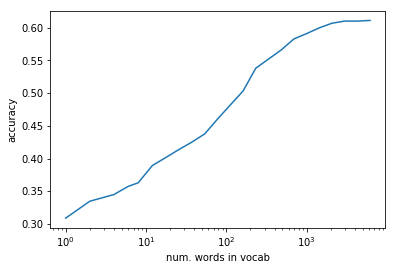

In [27]:
plt.plot(curve_data.keys(), curve_data.values())
plt.xscale('log')
plt.xlabel('num. words in vocab')
plt.ylabel('accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.show()

## Subject ablation attack

In [ ]:
counts_list = []
top_k = 5
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs, predicted_answer, correct_answer, is_correct, image_id = line.split('\t')
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split(','):
            if len(word_attr.split('|')) < 2:
                print('skipped')
                continue
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

In [ ]:
unattributed_words = set(vocab_json['question'].keys()) - set(counts_list)

In [ ]:
unattributed_words

In [ ]:
list(unattributed_words)[-10:]

In [ ]:
nlp = spacy.load('en')
sent = "how symmetrical are the white bricks on either side of the building"
doc=nlp(sent)

sub_toks = [tok for tok in doc if (tok.dep_ == "nobj") ]

print(sub_toks)

In [ ]:
[d.dep_ for d in doc]

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
attrs_tsv_string = ''
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
        out_string = ''
        for i in range(config.batch_size):
            if len(np.nonzero(a[i, :] >= 3))==0:
                continue
            answers = [reverse_vocab_answer[int(w)] for w in np.nonzero(a[i, :] >= 3)]
            if 'yes' in answers or 'no' in answers:
                continue
            string_question = [reverse_vocab_question[int(w)] if int(w) != 0 else '' for w in q[i, :]]
            out_string += '-'*50 + '\n'
            out_string += 'orig: ' + ' '.join(string_question) + '\n'
            out_string += 'answers: ' + ' '.join(answers) + '\n'
            doc = nlp(' '.join(string_question))
            pos_tags = [d.dep_ for d in doc]
            #print(pos_tags)
            subject_index = [i for i, t in enumerate(pos_tags) if 'nsubj' in t]
            if len(subject_index) == 0:
                continue
            q[i, subject_index[0]] = vocab_json['question']['civilian']
            string_question = [reverse_vocab_question[int(w)] if int(w) != 0 else '' for w in q[i, :]]
            out_string += 'ablated: ' + ' '.join(string_question) + '\n'

            
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        
        q_emb = embedding(q)
        
        out = net(v, q_emb, q_len)            
        
        acc = utils.batch_accuracy(out.data, a.data).cpu()
        
        _, answer = out.data.cpu().max(dim=1)
        
#        attrs_tsv_string = compute_attributions(q_emb, q_len, v, idx, num_batches=5)
        
#        outf.write(attrs_tsv_string)
        #for i in range(config.batch_size):
            #if int(acc[i]) >= 1.0:
                #print(out_string)
        
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        print(acc.mean())
        num_iters += 1
        batch_id += 1
        #print(' '.join([reverse_vocab_question[int(w)] for w in q[3,:] if int(w)!=0]))
        #print(acc[3])
        if num_iters == 5:
            break
            
#outf.close()

answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

print('final: ' + str(np.mean(accs)))

In [ ]:
reverse_vocab_answer[int(np.nonzero(a[0, :] > 3))]

In [ ]:
np.nonzero(a[i, :] >= 3)

## Image specific bias

In [ ]:
import json
import scipy.stats as stats
from collections import Counter

In [ ]:
json_data=open('/scratch/pramodkm/vqa/data_vqa1.0/OpenEnded_mscoco_val2014_questions.json').read()
data = json.loads(json_data)

In [ ]:
data['questions']

In [ ]:
json_data=open('/scratch/pramodkm/vqa/data_vqa1.0/mscoco_val2014_annotations.json').read()
annot_data = json.loads(json_data)

In [ ]:
annot_data['annotations']

In [ ]:
image_ans = dict()
for ans_annot in annot_data['annotations']:
    turk_answers = [ans['answer'] for ans in ans_annot['answers']]
    if ans_annot['image_id'] not in image_ans:
        image_ans[ans_annot['image_id']] = [turk_answers]
    else:
        image_ans[ans_annot['image_id']].append(turk_answers)

In [ ]:
image_ans

In [ ]:
def visualize_baseline_answers(tokens, attrs, image_ans):
    html_text = ""
    count = 0
    for i, tok in enumerate(tokens):
        r,g,b = get_color(attrs[i])
        val = []
        for ans in image_ans:
            val += [sum(tok == np.array(ans))]
        if sum(np.array(val)>=3)>0:
            tok = '<u>' + tok + '</u>'
            count += 1
        html_text += "<span style='size:16;color:rgb(%d,%d,%d)'>%s</span>, " % (r, g, b, tok)
    return html_text, count

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
outf = open('/scratch/pramodkm/vqa/tsv/baseline_answers.html','w')
html_str = '<html><head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
html_str += '<body><div class="container"> <h3> Top 15 answer classes for each image </h3><br>Generated by passing an empty question to the network. Underlined classes appear as answers to questions on the image. <br>'
html_str += '<table class="table">'
outf.write(html_str)

question = 'what color besides blue is there'
question_tokens = torch.LongTensor([vocab_json['question'][w] for w in question.strip().split()] + [0]*(23-len(question.strip().split())))
question_tokens = question_tokens.unsqueeze(0).repeat(config.batch_size,1)
new_q_len = torch.LongTensor([len(question.strip().split())])
new_q_len = new_q_len.repeat(config.batch_size)

covered_image_ids = set()

avg_count = []
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
        
        q = question_tokens
            
        q_len = new_q_len
        
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        
        q_emb = embedding(q)
                
        out = net(v, q_emb, q_len)    
        
        softmax = torch.nn.functional.softmax(out)
        
        acc = utils.batch_accuracy(out.data, a.data).cpu()
        
        _, answer = out.data.cpu().max(dim=1)

        # for baseline answers
        baseline_q = q * 0   
            
        baseline_q_len = q_len/q_len
        
        baseline_q_emb = embedding(baseline_q)
                
        baseline_out = net(v, baseline_q_emb, baseline_q_len)    
        
        baseline_softmax = torch.nn.functional.softmax(baseline_out)


        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            baseline_probs = [float(prob) for prob in baseline_probs]
            print_k = 15
            #outf.write('... ' + visualize_baseline_answers(baseline_answers[-10:], baseline_probs[-10:]))
            image_id = str(val_loader.dataset.coco_ids[int(idx[batch_i])])
            if image_id in covered_image_ids:
                continue
            covered_image_ids.add(image_id)
            #outf.write('<br>Question: ' + ' '.join([reverse_vocab_question[int(w)] for w in q[batch_i, :] if int(w)!=0]))
            #outf.write('<br>Pred. ans.: ' + reverse_vocab_answer[answer[batch_i]])
            outf.write('<br><tr><td><img src="val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg" width="256" height="256"></img></td>')
            vis_string, count = visualize_baseline_answers(baseline_answers[:print_k], baseline_probs[:print_k], image_ans[int(image_id)])
            avg_count.append(count)
            outf.write('<td>' + vis_string + '<br> #classes appearing as answers: ' + str(count) + '</td></tr>')
            
            outf.write('<hr>')
                
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        num_iters += 1
        batch_id += 1
        if num_iters == 1:
            break
            
outf.write('</table></div></body></html>')
outf.close()

print(np.mean(avg_count))
answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

In [ ]:
vocab_json['answer']['wood']

In [ ]:
tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
net.eval()
answ = []
idxs = []
accs = []
num_iters = 0
batch_id = 0
outf = open('/scratch/pramodkm/vqa/tsv/baseline_answers.html','w')
html_str = '<head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous"></head>'
html_str += '<body><div class="container"> '
outf.write(html_str)

question = 'how many are not'
question_tokens = torch.LongTensor([vocab_json['question'][w] for w in question.strip().split()] + [0]*(23-len(question.strip().split())))
question_tokens = question_tokens.unsqueeze(0).repeat(config.batch_size,1)
new_q_len = torch.LongTensor([len(question.strip().split())])
new_q_len = new_q_len.repeat(config.batch_size)

batch_percentages = np.zeros(3000)
for v, q, a, idx, q_len in tq:
        
        var_params = {
            'volatile': False,
            'requires_grad': False,        
        }
                
        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        question_tokens = Variable(question_tokens.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)
        new_q_len = Variable(new_q_len.cuda(async=True), **var_params)
        
        
        # for baseline answers
        baseline_q = q * 0   
            
        baseline_q_len = q_len/q_len
        
        baseline_q_emb = embedding(baseline_q)
                
        baseline_out = net(v, baseline_q_emb, baseline_q_len)    
        
        baseline_softmax = torch.nn.functional.softmax(baseline_out)

        
        test_k = 300          
        test_q = question_tokens


        batch_baseline_answers = []
        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            counter = 4
            for ba in baseline_answers[2:]:
                if counter == 7:
                    break
                if ba not in vocab_json['question']:
                    continue
                test_q[batch_i, counter] = vocab_json['question'][ba]
                counter += 1
            test_out = net(v, embedding(test_q), new_q_len)
            _, answer = test_out.data.cpu().max(dim=1)

        for batch_i in range(config.batch_size):
            baseline_probs, baseline_idxs = baseline_softmax[batch_i, :].sort(descending=True)
            baseline_answers = [reverse_vocab_answer[int(ix)] for ix in baseline_idxs]
            
            baseline_probs = [float(prob) for prob in baseline_probs]
            print_k = 100
            outf.write(visualize_baseline_answers(baseline_answers[:print_k], baseline_probs[:print_k]))
            outf.write('... ' + visualize_baseline_answers(baseline_answers[-10:], baseline_probs[-10:]))
            image_id = str(val_loader.dataset.coco_ids[int(idx[batch_i])])
            outf.write('<br>Question: ' + ' '.join([reverse_vocab_question[int(w)] for w in test_q[batch_i, :] if int(w)!=0]))
            outf.write('<br>Pred. ans.: ' + reverse_vocab_answer[answer[batch_i]])
            outf.write('<br><img src="val2014/COCO_val2014_' + '0'*(12 - len(str(image_id))) + str(image_id) + '.jpg" width="256" height="256"></img><br><br>')
            outf.write('<hr>')
                      
        

        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        num_iters += 1
        batch_id += 1
        if num_iters == 1:
            break
            
outf.write('</div></body>')
outf.close()
answ = list(torch.cat(answ, dim=0))
accs = list(torch.cat(accs, dim=0))
idxs = list(torch.cat(idxs, dim=0))

In [ ]:
plt.plot(batch_percentages[:300]/300)

In [ ]:
batch_percentages/300

In [ ]:
vocab_json['question']['rooster']

In [ ]:
set(vocab_json['question'].keys()) - set(vocab_json['answer'].keys())